# DAE for Plasma Dignostic

Plasma accelerator is one of the important tools in science, plasma acceleration has made great progress and promises a cheaper in a smaller scale acceleration.  Considering the fact that plasma wake-field acceleration is working based on the plasma wave oscillation, having a clear knowledge of plasma frequency is a crucial part of the PWFA to avoid decelerating. Fortunately, due to the dependency of plasma frequency on the plasma density, by investigation on plasma density using the stark broadening, a clear knowledge of plasma frequency would be achievable. 

However, measuring the plasma density by spectrometer is not always easy, sometimes due to the bad alignment of mirrors and lenses, or due to the low applied voltage on the plasma, the result is noisy, and measuring the denisty is challenging. 



In this project, we want to use the Neural network, to denoise the low voltage results by learning from the result of high voltage which usually are more clean and visible.


In [1]:
# Importing all the important libraries

import matplotlib.pyplot as plt   
import numpy as np
from PIL import Image
import skimage
import os
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

import random
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import torchsummary

# The Neural Network architecture

Here, we build our model, we have Encoder, and Decoder


# Encoder

In [2]:
# defining our encoder layers

# we apply three 2D convolutions, BatchNormalisation, flatten and two linear layers and The rectified linear activation function

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),   # BatchNormalisation makes sure that the values of hidden units have standardized mean and variance
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### To apply a linear layer after a convolutional one you should convert your tensor to a monodimensional array by a Flatten layer  
        self.flatten =nn.Flatten(start_dim=1)   # dimension 0 is the sample, so we flatten from dimension 1
           
       
        ### Linear section
        self.encoder_lin = nn.Sequential(
        nn.Linear(32*31*127, 128),
        nn.ReLU(True),
        nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x


# Decoder 

In [3]:
# defining our decoder layers

# we implement a decoder as a reversed encoder architecture, so we have two linear layers , one unflatten, and three up-scaling 2D Convolutions with the activation function

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        ## Linear
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 32*31*127),
            nn.ReLU(True)
        )
        ## Unflatten
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32,31,127))
        
       ##Transposed Convolutions
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

# Initiallizing the Network & Training 


In [4]:
### Set the random seed for reproducible results
torch.manual_seed(0)

# Initiallizing the networks

encoded_space_dim=1  # since, our image files have image mode " I ", they have only one dimension 
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

### Define the loss function 
# MSE stands for mean square error which is the most commonly used loss function
loss_fn = torch.nn.MSELoss()

### we defined the Adam optimizer for both encoder and decoder
lr = 1e-2
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check the available device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(' The device is **{}**'.format (device))



# printing a summary of NN network encoder and the decoder to the selected device 
print(encoder.to(device))
print(decoder.to(device))
print(torchsummary.summary(encoder.to(device),(1,256,1024)))


 The device is **cuda**
Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=125984, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)
Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=125984, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 31, 127))
  (decoder_conv): Sequential(
    

# Training Function 

In [5]:
### Training function will train the network for each epoch
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_fac):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    
    for img in dataloader: #for each batch  in the data loader, it adds noise and then send it to network
        # add the gaussian noise and move tensor to the proper device
        image_noisy =noise_maker(img,noise_fac).to(device)
        main_image = img.to(device)   # keep the main image for evaluate the loss
        # Encode data
        encoded_data = encoder(image_noisy)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, main_image)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('Partial Train loss is {}'.format(loss.data))
        train_loss.append(loss.detach().cpu().numpy()) #keeping all the losses as np array

    return np.mean(train_loss)

# Validation function

In [6]:
### Validation function to evaluate how well we are reproducing the input

def vali_epoch_den(encoder, decoder, device, dataloader, loss_fn,noise_fac):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs and inputs for each batch
        after = []
        before = []
        for img in dataloader:
            # Add noise and move the tensor to the proper device
            image = noise_maker(img,noise_fac).to(device)
            # Encode data
            encoded_data = encoder(image)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            after.append(decoded_data.cpu())
            before.append(img.cpu())
        # Create a single tensor with all the values in the lists
        after = torch.cat(after)
        before = torch.cat(before) 
        # Evaluate global loss
        val_loss = loss_fn(after,before)
        print(' \n Global  validation loss for this epoch  is {} '.format(val_loss.data))
    return val_loss.data

# Noise Function

In [7]:
# define a  function for adding noise to clean data
def noise_maker(inputs,noise_factor): 
    noisy=inputs+torch.randn_like(inputs)*noise_factor # to create a noisy tensor of the same size of the input
    noisy=torch.clamp(noisy,0.,1)  #  to limit the range between 0 and 1
    return noisy


# Initial Data Function

In [8]:
# Initial data function has been defined for plotting the samples that we have, whether the clean and noisy, plus the result of adding the noise 

def compare(clean,train_dataset,noise,noise_factor,rand):
    
    # Here, we add noise to our clean data set, and conver it to numpy for plotting it
    noisy_sam=noise_maker(train_dataset,noise_factor)
    noisy_sam=noisy_sam.cpu().permute(0,2,3,1).squeeze().numpy()
    
    # By defining the range, you can choose how many samples to be shown, in our case it's only one sample
    rangee=1
    for i in range(rangee): 
        plt.subplot(1,3,1)
        plt.imshow(clean[rand+i])   # The first one is clean image
        plt.title('Sample {} of clean data'.format(rand+i))
        plt.subplot(1,3,2)
        plt.imshow(noisy_sam[rand+i])    # the second one is the clean data after adding the noise
        plt.title('Sample {} of clean data with noise'.format(rand+i))
        plt.subplot(1,3,3)
        plt.imshow(noise[rand+i])  # the third one is noisy image that we want to denoise it
        plt.title('Sample {} of noisy data'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
        plt.show()
    
    
    
    
    # Here, we check one of the longitudinal spectrum of our images which we usually use in measuring the plasma density 
    x=np.linspace(0,1024,1024)
    for i in range(rangee):
        plt.subplot(1,3,1)
        plt.plot(x,clean[rand+i][150])     # The first one is spetrum from clean image
        plt.title('Clean spectrum of sample {}'.format(rand+i))
        plt.subplot(1,3,2)
        plt.plot(x,noisy_sam[rand+i][150])     # the second one is the spectrum from clean data after adding the noise
        plt.title('added noise to clean spectrum of sample {}'.format(rand+i))
        plt.subplot(1,3,3)
        plt.plot(x,noise[rand+i][150])  # the third one is the spectrum from noisy image that we want to denoise it
        plt.title('noisy spectrum of sample {}'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
        plt.show()
    

# Initial Results Function

In [9]:
# This function sends the noisy samples to our model, and plot the final results of denoising

def plotting(test_data,encoder,decoder,rand):
    
     # move the tensor to proper device and Set evaluation mode for encoder and decoder
    img = test_data.to(device)
    encoder.eval()
    decoder.eval()
        
    with torch.no_grad(): ## No need to track the gradients
        rec_img  = decoder(encoder(img)) #implement the model
          
     # Preparing the samples and results as numpy array to plot them   
    original=img.cpu().permute(0,2,3,1).squeeze().numpy()
    denoised=rec_img.cpu().permute(0,2,3,1).squeeze().numpy()
    
     # By defining the range, you can choose how many samples to be shown, in our case it's only one sample
    rangee=1   
    # we used the same codes as above to show the final results both for each image and its spectrum
    for i in range(rangee):  
        plt.subplot(1,2,1)
        plt.imshow(original[rand+i],cmap='binary')
        plt.title('Sample {} of  noisy images '.format(rand+i))
        plt.subplot(1,2,2)
        plt.imshow(denoised[rand+i],cmap='binary')
        plt.title('Sample {} of denoised images'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
        
        plt.show()
        
    x=np.linspace(0,1024,1024)
    for i in range(rangee):
        plt.subplot(1,2,1)
        plt.plot(x,original[rand+i][100])
        plt.title(' Spectrum sample {} of Noisy images'.format(rand+i))
        plt.subplot(1,2,2)
        plt.plot(x,denoised[rand+i][100])
        plt.title('Spectrum sample {} of denoised images'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
        plt.show()
   
    return(denoised)

# Final Analysis Function

In [10]:
# This function is defiend to analyse the final images and tries to fit the spectrum by Lorentzian function, and using the Stark-Broadning formula, measure the density and give us the density Profile
# this function has been developed by me and two of my classmates during our lab project ( Chaitanya Varma and Sara Molisani)
# what we do here is 
def main(final):

    Mnd, MCv, MAv, MWv, MPv, MDv, MDl= [],[],[],[],[],[],[]
    for dim in range(len(final)):

        data=final[dim]
        N=len(data)
        lda=np.zeros(N) #array for density value at each transverse section / longitudinal dimenion
        tda=np.zeros(1024) # transverse section dimension

        # Defined set of cuts for a particular image
        c1= 159
        c2= 861

        # Size of the range of pixels in use
        N1= c2-c1

        # Array to work with for an image
        nd=[]
        cval, aval, wval, pval, dval= [],[],[],[],[]

        ## Fitting function details: We use a 3 parameter lorentzian with a push 
        def Lorentzian(x, amp, cen, hw, push):
            return (push+(amp*hw**2/((x-cen)**2+hw**2)))

        xpos=np.linspace(c1,c2,N1+1)      # Array for storing the x-values for fitting

        # Calibration of actual length with pixel size representation
        pixel= 0.072 # transversal calibration 0.072 [nm/pixel]
        alpha= 0.0225    # other alpha was around 0.0918
        LC= 150000 # nm/pixel is the longitudinal calibration


        #plt.figure()
        for i in range(N):

            tda=data[i] 
            ta= []

            for j in range(1024):
                if j>=c1 and j<=c2:
                    ta.append(tda[j])

            hpi=ta.index(max(ta))+c1 # This calculates the value of the index containing the highest point on a row of data
            #print(hpi)
            if (hpi>380 and hpi<460): # condition to reduce misplaced lorentzians
            # We begin fitting the data for each of the rows of pixels for the image
                while True:
                    try:
                        popt, pcov = curve_fit(Lorentzian, xdata= xpos, ydata= ta, p0= [40000, 415, 100, 1700]) # try 415 for cen
                        break
                    except(RuntimeError):
                        popt, pcov = curve_fit(Lorentzian, xdata= xpos, ydata= ta, p0= [35000, 415, 100, 1700], bounds=[(18000, 400, 0, 1000),(50000, 600, 150, 2000)])
                        break
                    else:
                        pass
                #print(popt[0])
                aval.append(popt[0])
                cval.append(popt[1]+c1)
                wval.append(abs(popt[2]*2))
                pval.append(popt[3])
                nd.append(ta)

                delta_lambda = pixel*(abs(popt[2]*2)) #delta of wavelength that we need for Stark formula
                dval.append(8.02*(10**12)*(delta_lambda*10/alpha)**1.5) # density in cm-3

            else: # if highest point is not in the central region we put to zero the values of this transverse section

                aval.append(0)
                cval.append(0)
                wval.append(0)
                pval.append(0)
                nd.append(0)
                dval.append(0) # density in cm-3

        #plt.show()
        # store the values of every image
        Mnd.append(nd)
        MCv.append(cval)
        MAv.append(aval)
        MWv.append(wval)
        MPv.append(pval)
        MDv.append(dval)

    Mnd1= np.asarray(Mnd)
    MCv1= np.asarray(MCv)
    MAv1= np.asarray(MAv)
    MWv1= np.asarray(MWv)
    MPv1= np.asarray(MPv)
    MDv1= np.asarray(MDv)
    return(MDv1, final, N)



def beaut(MDv1, final, N):

    xar= np.linspace(0,254,N)
    lc= 150000*10**(-6) # mm/pixel is the longitudinal calibration
    pos_cal=np.linspace(0,254,N)*lc

    cia=np.zeros([2,N]) # Array to hold values for the mean and the std (from ebm)
    for i in range(N):
        ebm=[] # Array to store values for the error bar measurement
        # For each of the points in the long. dir. of the capillary, we calculate the average density and the std. dev. considering the 50 images
        for j in range(0,len(final)):
            if (MDv1[j][i]>0): #not considering the transv. sections put at zero before
                ebm.append(MDv1[j][i]) 
        cia[0][i]= np.mean(ebm)
        cia[1][i]= np.std(ebm)

    print('Relative error at center of capillary:', cia[1][120]/(2*cia[0][120]))
    s=' 3cmx1mm \n 600A_600mb \n 1500ns'
    fig, ax = plt.subplots()
    plt.xlabel(' Longitudinal position [mm]')
    plt.ylabel(' Plasma Density [cm-3]')
    plt.text(0,0.8,s,transform=ax.transAxes)
    #plt.text(0,9.4*10**17,s)
    plt.title('Density profile')
    ax.errorbar(pos_cal, cia[0], yerr=cia[1],fmt='.', markersize=1.5, ecolor='black', elinewidth=0.1)
    plt.ylim(0.5*10**17, 4*10**17)
    #plt.axvline(mm)
    plt.savefig('3x1_600A_1500ns_600mb', dpi='figure', format='pdf')
    plt.show()
    

# Since most parts of our Model have been defined, we start to import our data

# Importing the data

In [11]:
# If the folder of data exsists, nothing happens, but if we don't have the folder, it will extract the folders

path= r"sagemaker-studiolab-notebooks/AML project/v3.0"
if  os.path.exists('4kv_2500_clean'):
    print('The folders are already there')
else:
    a=!unzip all.zip



The folders are already there


In [12]:
# Importing the images seperately for noisy and clean one
    
clean= []
for fname in os.listdir('4kv_2500_clean'):
    im = Image.open(os.path.join('4kv_2500_clean', fname))  # importing the clean images
    # The size of the images are (1024,255), to have a better padding and better performance we resized the images to (1024,256)
    im=im.resize((1024,256))  
    
    # putting the images into an Numpy array
    im=skimage.img_as_float(im) 
    clean.append(im)

clean=np.asarray(clean)
print('There are {} samples of clean images with shape {}'.format(np.shape(clean)[0],np.shape(clean[1])))
    
# Doing the same as above for noisy images    
noise=[]
for fname in os.listdir('4kv_1000_noise'):
    im = Image.open(os.path.join('4kv_1000_noise', fname))
    im=im.resize((1024,256))
    im=skimage.img_as_float(im)
    noise.append(im)

noise=np.asarray(noise)

print('There are {} samples of noisy images with shape {}'.format(np.shape(noise)[0],np.shape(noise[1])))


There are 250 samples of clean images with shape (256, 1024)
There are 549 samples of noisy images with shape (256, 1024)


#  Data preparation

In [13]:
# By each time running this part, it adds another dimension to our data set, I defined an empty array at the beginning to prevent this problem.
train_dataset=[]
test_dataset=[]

# extending channel dimension since the 2D convultion accepts and array as (channels,dimension of images, dim2,dim3)
# Since the mode of our images are "I" it has dimension one
clean=np.expand_dims(clean, -1)
noise=np.expand_dims(noise, -1)
print('Shape of our data as a numpy array is {}'.format(np.shape(clean)))

# Converting the numpy array to torch tensor 

train_dataset = torch.Tensor(clean)
test_dataset = torch.Tensor(noise)
print('Shape of our data as a pytorch tensor is {}'.format(train_dataset.shape))

#permuting the shape of our data to be suitable for the model

train_dataset=train_dataset.permute(0,3,1,2)
test_dataset=test_dataset.permute(0,3,1,2)
print('Appropriate Shape of our data for dataLoader {}'.format(train_dataset.shape))


Shape of our data as a numpy array is (250, 256, 1024, 1)
Shape of our data as a pytorch tensor is torch.Size([250, 256, 1024, 1])
Appropriate Shape of our data for dataLoader torch.Size([250, 1, 256, 1024])


# Dataset Transform

In [14]:
# Without any modification, we transform the data to tensors

train_transform=transforms.Compose([transforms.ToTensor(),])
test_transform=transforms.Compose([transforms.ToTensor(),])

train_transform.transform=train_transform
test_transform.transform=test_transform


# training, validation, test split
# Instead of Sklearn, we splitted our data to training and validation by random split
m=len(train_dataset)
train_data,val_data=random_split(train_dataset,[int(np.round(m-m*0.2)),int(np.round((m*0.2)))])

print('The train set has {} samples.'.format(len(train_data)))
print('The validation set has {} samples.'.format(len(val_data)))
print('The test-set has {} samples.'.format(len(test_dataset)))


The train set has 200 samples.
The validation set has 50 samples.
The test-set has 549 samples.


# Data Loader

In [15]:
# We define our train, test, and validation Loaders by having batch size of 10
batch_size=10
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size)
valid_loader=torch.utils.data.DataLoader(val_data,batch_size=batch_size)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

data = next(iter(train_loader))
print(' Our train batch shape is {}'.format(data.shape))
batch_data = next(iter(valid_loader))
print(' Our validation batch shape is {}'.format(data.shape))
data = next(iter(test_loader))
print(' Our test batch shape is {}'.format(data.shape))

 Our train batch shape is torch.Size([10, 1, 256, 1024])
 Our validation batch shape is torch.Size([10, 1, 256, 1024])
 Our test batch shape is torch.Size([10, 1, 256, 1024])


# Initial data

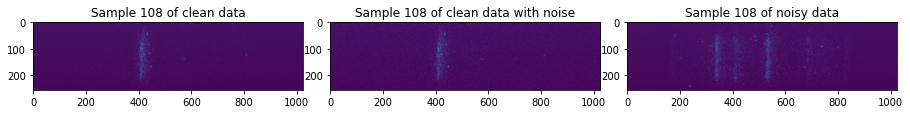

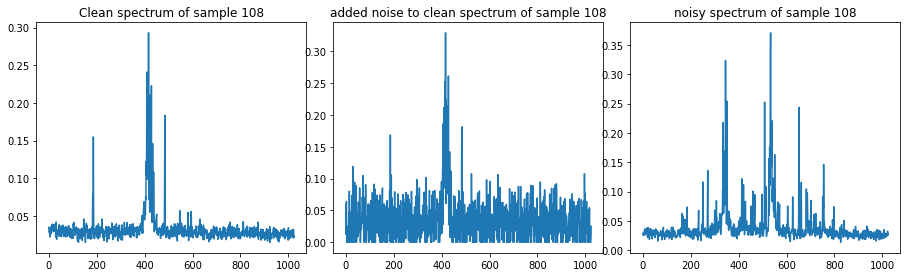

In [16]:
# By choosing random images , we start to show the data, before applying the DAE network
rand=np.random.randint(0,len(clean))
noise_factor=0.03
compare(clean,train_dataset,noise,noise_factor,rand)

# Training Loop

EPOCH 1 / 50
Partial Train loss is 0.1765679568052292
Partial Train loss is 0.153495654463768
Partial Train loss is 0.13915589451789856
Partial Train loss is 0.12008314579725266
Partial Train loss is 0.10748584568500519
Partial Train loss is 0.0954073965549469
Partial Train loss is 0.08129554986953735
Partial Train loss is 0.07408390194177628
Partial Train loss is 0.06427347660064697
Partial Train loss is 0.05393587425351143
Partial Train loss is 0.04927262291312218
Partial Train loss is 0.0423189178109169
Partial Train loss is 0.037089746445417404
Partial Train loss is 0.03210494667291641
Partial Train loss is 0.028619324788451195
Partial Train loss is 0.02548852376639843
Partial Train loss is 0.022389143705368042
Partial Train loss is 0.02001124620437622
Partial Train loss is 0.017956232652068138
Partial Train loss is 0.0149459857493639
 
 Global  validation loss for this epoch  is 0.024566274136304855 

 EPOCH 1/50 	 train loss 0.068 	 val loss 0.025


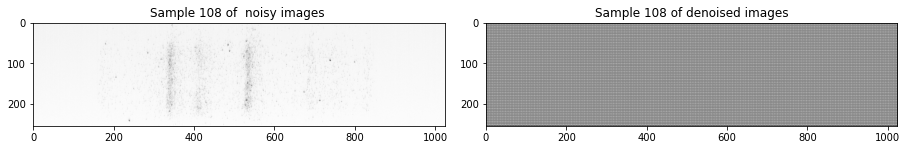

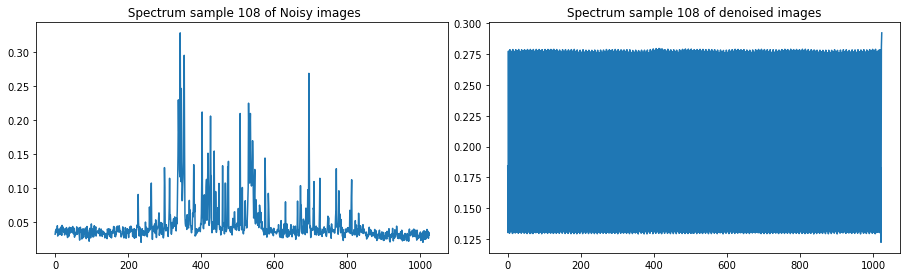

EPOCH 2 / 50
Partial Train loss is 0.013785413466393948
Partial Train loss is 0.013043018989264965
Partial Train loss is 0.011741694062948227


[W accumulate_grad.h:185] Warning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [8, 1, 3, 3], strides() = [9, 9, 3, 1]
param.sizes() = [8, 1, 3, 3], strides() = [9, 1, 3, 1] (function operator())


Partial Train loss is 0.009949528612196445
Partial Train loss is 0.009098151698708534
Partial Train loss is 0.008246758952736855
Partial Train loss is 0.006965263281017542
Partial Train loss is 0.006734332535415888
Partial Train loss is 0.00593128427863121
Partial Train loss is 0.004937724210321903
Partial Train loss is 0.004813750274479389
Partial Train loss is 0.0042478772811591625
Partial Train loss is 0.0039655244909226894
Partial Train loss is 0.003577339230105281
Partial Train loss is 0.003357763634994626
Partial Train loss is 0.003102001268416643
Partial Train loss is 0.00291626900434494
Partial Train loss is 0.0027277201879769564
Partial Train loss is 0.0026007869746536016
Partial Train loss is 0.002343980595469475
 
 Global  validation loss for this epoch  is 0.004092203453183174 

 EPOCH 2/50 	 train loss 0.006 	 val loss 0.004


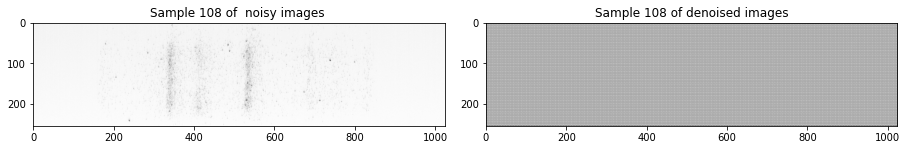

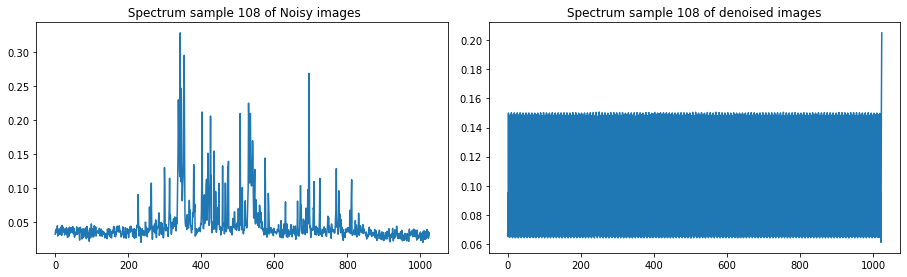

EPOCH 3 / 50
Partial Train loss is 0.0021858615800738335
Partial Train loss is 0.0021030677016824484
Partial Train loss is 0.002000559587031603
Partial Train loss is 0.0018579878378659487
Partial Train loss is 0.0018409088952466846
Partial Train loss is 0.0017513238126412034
Partial Train loss is 0.001635141670703888
Partial Train loss is 0.001626888639293611
Partial Train loss is 0.0015307836001738906
Partial Train loss is 0.0014275824651122093
Partial Train loss is 0.001386650139465928
Partial Train loss is 0.0013045532396063209
Partial Train loss is 0.0013529156567528844
Partial Train loss is 0.001302773947827518
Partial Train loss is 0.0012597398599609733
Partial Train loss is 0.0011768282856792212
Partial Train loss is 0.0012233828892931342
Partial Train loss is 0.0011867330176755786
Partial Train loss is 0.0012021156726405025
Partial Train loss is 0.0012347911251708865
 
 Global  validation loss for this epoch  is 0.002193439519032836 

 EPOCH 3/50 	 train loss 0.002 	 val loss 0

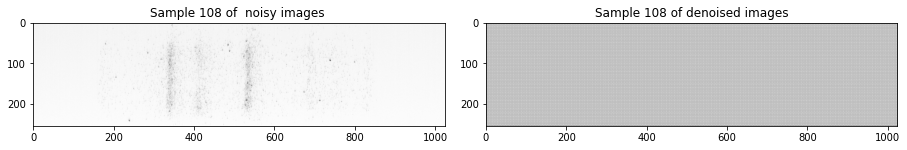

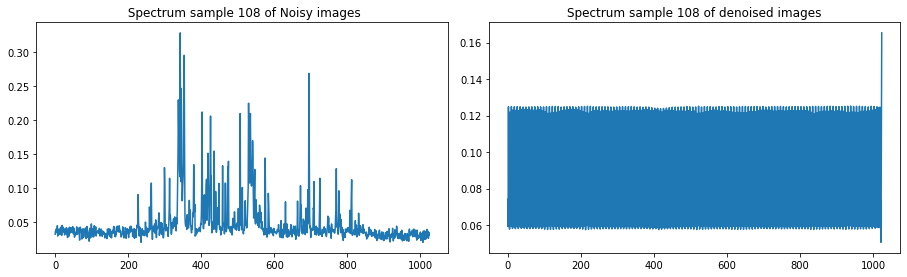

EPOCH 4 / 50
Partial Train loss is 0.0011204058537259698
Partial Train loss is 0.0011778598418459296
Partial Train loss is 0.0010163141414523125
Partial Train loss is 0.0010046155657619238
Partial Train loss is 0.0010134943295270205
Partial Train loss is 0.0009743690607137978
Partial Train loss is 0.0010061421198770404
Partial Train loss is 0.0009565444779582322
Partial Train loss is 0.0009418253903277218
Partial Train loss is 0.0009762654080986977
Partial Train loss is 0.0008791031432338059
Partial Train loss is 0.0008744819206185639
Partial Train loss is 0.0009433381492272019
Partial Train loss is 0.0009416946559213102
Partial Train loss is 0.0009142932831309736
Partial Train loss is 0.0008426472777500749
Partial Train loss is 0.0009107252699322999
Partial Train loss is 0.0008448483422398567
Partial Train loss is 0.0008340654894709587
Partial Train loss is 0.000936578493565321
 
 Global  validation loss for this epoch  is 0.0016382858157157898 

 EPOCH 4/50 	 train loss 0.001 	 val l

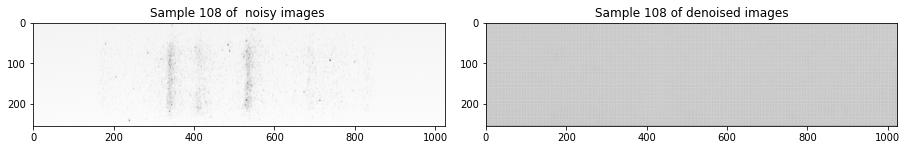

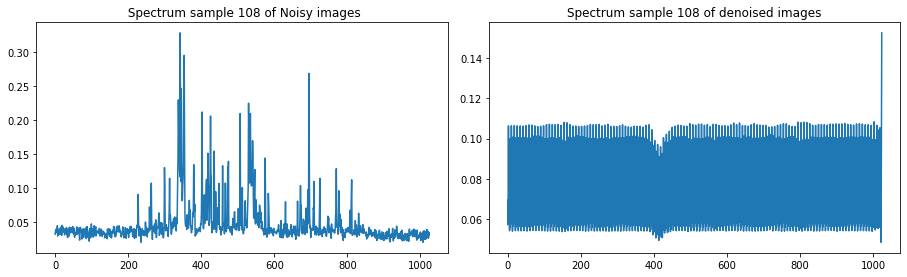

EPOCH 5 / 50
Partial Train loss is 0.0008421521633863449
Partial Train loss is 0.0009316133218817413
Partial Train loss is 0.0007499656639993191
Partial Train loss is 0.0007836399599909782
Partial Train loss is 0.0007796130958013237
Partial Train loss is 0.0007501062355004251
Partial Train loss is 0.0008087879978120327
Partial Train loss is 0.0007500524516217411
Partial Train loss is 0.0007599981036037207
Partial Train loss is 0.0008002753602340817
Partial Train loss is 0.0007423622882924974
Partial Train loss is 0.0008113067015074193
Partial Train loss is 0.0008221620810218155
Partial Train loss is 0.000823825248517096
Partial Train loss is 0.0007747769705019891
Partial Train loss is 0.0006822223076596856
Partial Train loss is 0.0007531906594522297
Partial Train loss is 0.000700765463989228
Partial Train loss is 0.0006877413252368569
Partial Train loss is 0.0008040158427320421
 
 Global  validation loss for this epoch  is 0.0016587823629379272 

 EPOCH 5/50 	 train loss 0.001 	 val lo

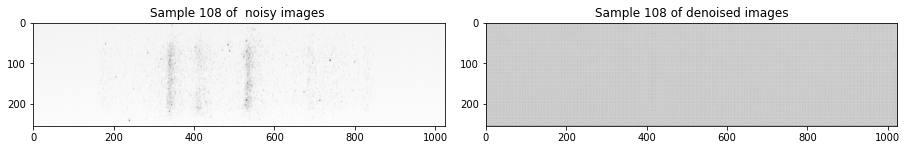

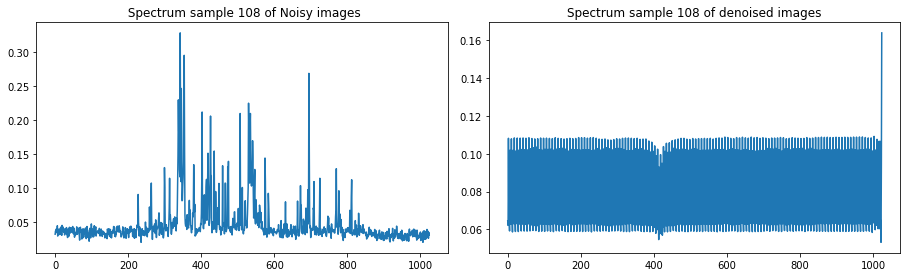

EPOCH 6 / 50
Partial Train loss is 0.0007054413435980678
Partial Train loss is 0.0008057119557633996
Partial Train loss is 0.0006357782986015081
Partial Train loss is 0.000664984283503145
Partial Train loss is 0.0006667698617093265
Partial Train loss is 0.000637025514151901
Partial Train loss is 0.000706609571352601
Partial Train loss is 0.0006683374522253871
Partial Train loss is 0.0007604411221109331
Partial Train loss is 0.0007397913723252714
Partial Train loss is 0.0006944371270947158
Partial Train loss is 0.0006403523148037493
Partial Train loss is 0.0007311230292543769
Partial Train loss is 0.0007348523940891027
Partial Train loss is 0.0006778002716600895
Partial Train loss is 0.0006043682224117219
Partial Train loss is 0.0006580539047718048
Partial Train loss is 0.0006077266298234463
Partial Train loss is 0.0006009869393892586
Partial Train loss is 0.0007179311942309141
 
 Global  validation loss for this epoch  is 0.0010415875585749745 

 EPOCH 6/50 	 train loss 0.001 	 val los

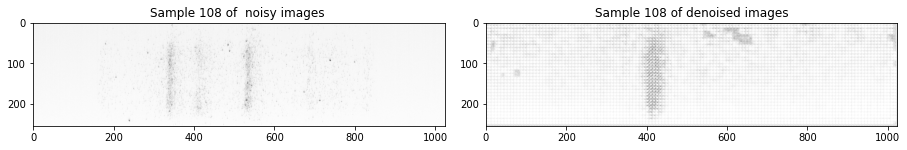

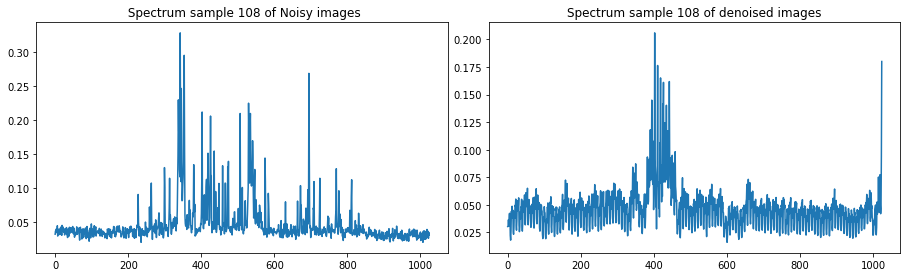

EPOCH 7 / 50
Partial Train loss is 0.0006239972426556051
Partial Train loss is 0.0007257338729687035
Partial Train loss is 0.0005732980207540095
Partial Train loss is 0.0006007885094732046
Partial Train loss is 0.0006017382256686687
Partial Train loss is 0.0005635267007164657
Partial Train loss is 0.0006193309091031551
Partial Train loss is 0.0005833423347212374
Partial Train loss is 0.0005856509669683874
Partial Train loss is 0.0006580337649211287
Partial Train loss is 0.0005387997953221202
Partial Train loss is 0.000536126084625721
Partial Train loss is 0.0006207060068845749
Partial Train loss is 0.0006162542849779129
Partial Train loss is 0.0005855954368598759
Partial Train loss is 0.0005066469311714172
Partial Train loss is 0.0005717407329939306
Partial Train loss is 0.0005315661546774209
Partial Train loss is 0.0005462334956973791
Partial Train loss is 0.0006351526826620102
 
 Global  validation loss for this epoch  is 0.0013382431352511048 

 EPOCH 7/50 	 train loss 0.001 	 val l

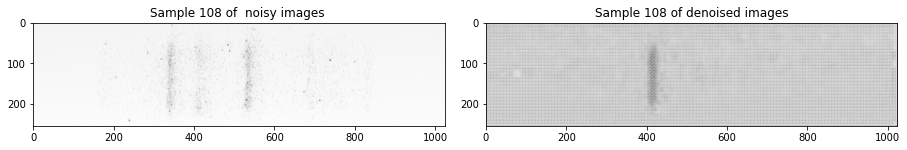

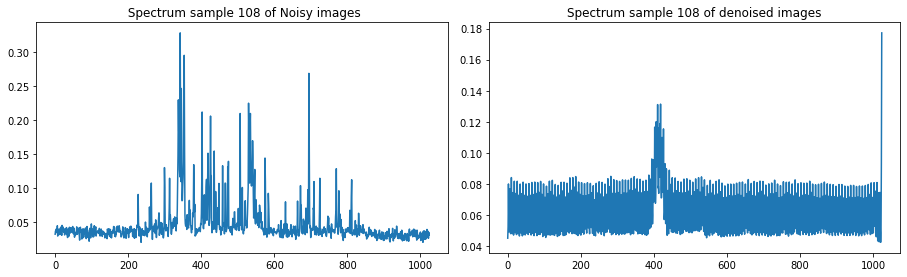

EPOCH 8 / 50
Partial Train loss is 0.0005642629112116992
Partial Train loss is 0.0006445930339396
Partial Train loss is 0.0004916336620226502
Partial Train loss is 0.000514754734467715
Partial Train loss is 0.0005245842621661723
Partial Train loss is 0.00048529962077736855
Partial Train loss is 0.0005488753085955977
Partial Train loss is 0.0005156366969458759
Partial Train loss is 0.0005045696161687374
Partial Train loss is 0.0005750629352405667
Partial Train loss is 0.0004636064113583416
Partial Train loss is 0.0004643962311092764
Partial Train loss is 0.0005441071116365492
Partial Train loss is 0.0005434383056126535
Partial Train loss is 0.0005171723896637559
Partial Train loss is 0.0004479459021240473
Partial Train loss is 0.0005100672133266926
Partial Train loss is 0.00047196383820846677
Partial Train loss is 0.00047125472337938845
Partial Train loss is 0.0005790329305455089
 
 Global  validation loss for this epoch  is 0.0015795372892171144 

 EPOCH 8/50 	 train loss 0.001 	 val l

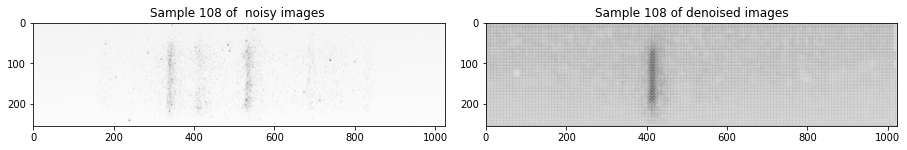

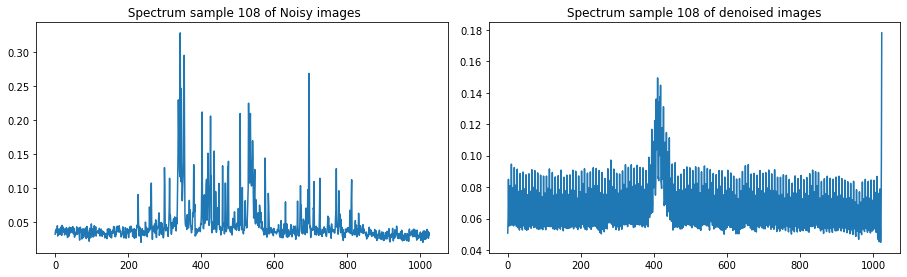

EPOCH 9 / 50
Partial Train loss is 0.0004948775749653578
Partial Train loss is 0.0005760769709013402
Partial Train loss is 0.0004438363539520651
Partial Train loss is 0.00046997840399853885
Partial Train loss is 0.0004777875728905201
Partial Train loss is 0.0004338705912232399
Partial Train loss is 0.0004972128081135452
Partial Train loss is 0.00045932919601909816
Partial Train loss is 0.00044719252036884427
Partial Train loss is 0.000523050723131746
Partial Train loss is 0.0004100205551367253
Partial Train loss is 0.0004138181102462113
Partial Train loss is 0.0004869023396167904
Partial Train loss is 0.0004883595975115895
Partial Train loss is 0.00046231644228100777
Partial Train loss is 0.0004012972058262676
Partial Train loss is 0.0004526641278062016
Partial Train loss is 0.00041976990178227425
Partial Train loss is 0.00041385117219761014
Partial Train loss is 0.0005229745875112712
 
 Global  validation loss for this epoch  is 0.0008757364121265709 

 EPOCH 9/50 	 train loss 0.000 	

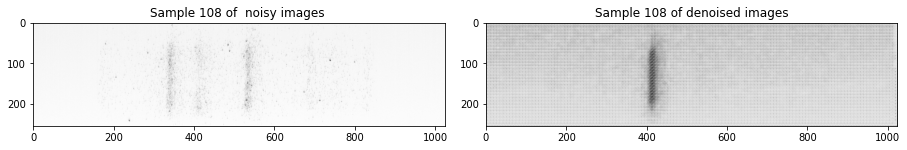

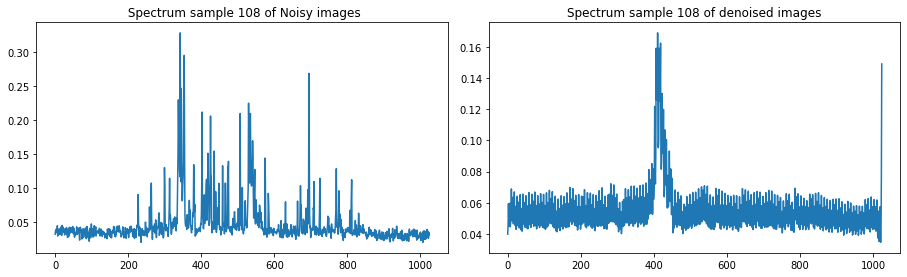

EPOCH 10 / 50
Partial Train loss is 0.0004464040684979409
Partial Train loss is 0.0005298462347127497
Partial Train loss is 0.0003981972695328295
Partial Train loss is 0.0004269388155080378
Partial Train loss is 0.0004299621214158833
Partial Train loss is 0.000394562172004953
Partial Train loss is 0.0004524220712482929
Partial Train loss is 0.0004158700758125633
Partial Train loss is 0.0004086722619831562
Partial Train loss is 0.00047725351760163903
Partial Train loss is 0.00037959436303935945
Partial Train loss is 0.0003754232020583004
Partial Train loss is 0.00044812445412389934
Partial Train loss is 0.0004434407746884972
Partial Train loss is 0.000418423063820228
Partial Train loss is 0.0003631889703683555
Partial Train loss is 0.0004116828495170921
Partial Train loss is 0.00038519754889421165
Partial Train loss is 0.00038374747964553535
Partial Train loss is 0.0004787744546774775
 
 Global  validation loss for this epoch  is 0.0007007208187133074 

 EPOCH 10/50 	 train loss 0.000 	

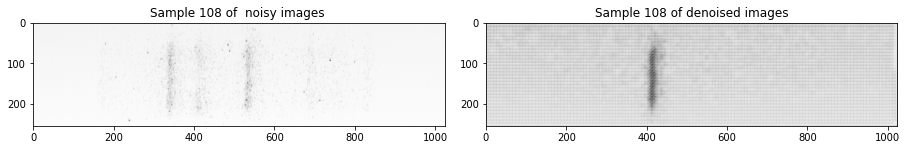

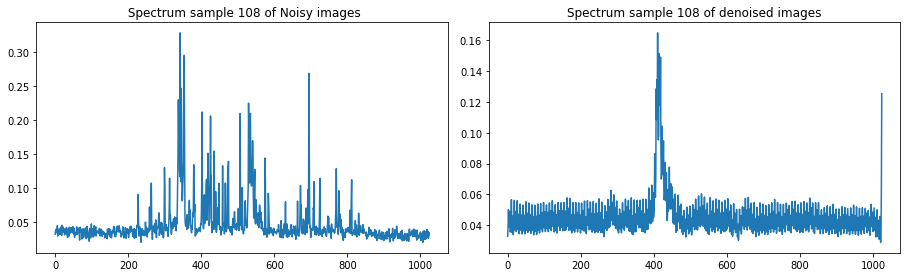

EPOCH 11 / 50
Partial Train loss is 0.0004128662112634629
Partial Train loss is 0.0004826980584766716
Partial Train loss is 0.0003656713815871626
Partial Train loss is 0.00038504134863615036
Partial Train loss is 0.0003955013526137918
Partial Train loss is 0.00036235793959349394
Partial Train loss is 0.0004137272189836949
Partial Train loss is 0.0003873113601002842
Partial Train loss is 0.00037729612085968256
Partial Train loss is 0.00044862154754810035
Partial Train loss is 0.0003562087658792734
Partial Train loss is 0.0003483069594949484
Partial Train loss is 0.00041732119279913604
Partial Train loss is 0.00041187764145433903
Partial Train loss is 0.00038640908314846456
Partial Train loss is 0.0003353623324073851
Partial Train loss is 0.0003810964699368924
Partial Train loss is 0.00035286624915897846
Partial Train loss is 0.00035484167165122926
Partial Train loss is 0.00044524643453769386
 
 Global  validation loss for this epoch  is 0.0006147840758785605 

 EPOCH 11/50 	 train loss 

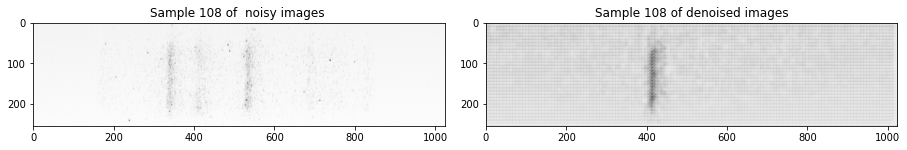

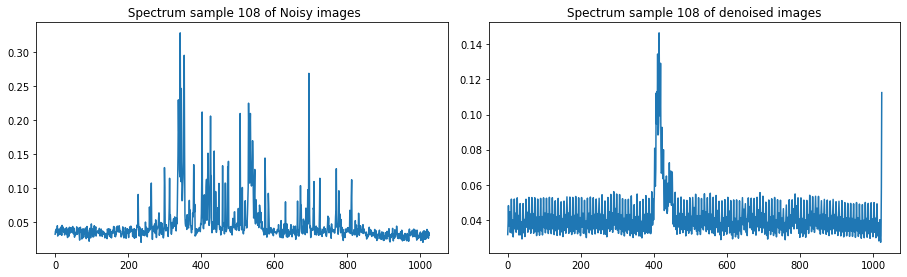

EPOCH 12 / 50
Partial Train loss is 0.0003773147182073444
Partial Train loss is 0.0004445555678103119
Partial Train loss is 0.00034161764779128134
Partial Train loss is 0.000364973908290267
Partial Train loss is 0.0003695040359161794
Partial Train loss is 0.0003418353444430977
Partial Train loss is 0.0003862291050609201
Partial Train loss is 0.0003613066510297358
Partial Train loss is 0.00035217401455156505
Partial Train loss is 0.00041519859223626554
Partial Train loss is 0.0003338635142426938
Partial Train loss is 0.00032392784487456083
Partial Train loss is 0.0003895907138939947
Partial Train loss is 0.0003855601535178721
Partial Train loss is 0.00036084497696720064
Partial Train loss is 0.00031785888131707907
Partial Train loss is 0.0003587242099456489
Partial Train loss is 0.0003339672402944416
Partial Train loss is 0.0003303368284832686
Partial Train loss is 0.0004114740586373955
 
 Global  validation loss for this epoch  is 0.0003222977975383401 

 EPOCH 12/50 	 train loss 0.000

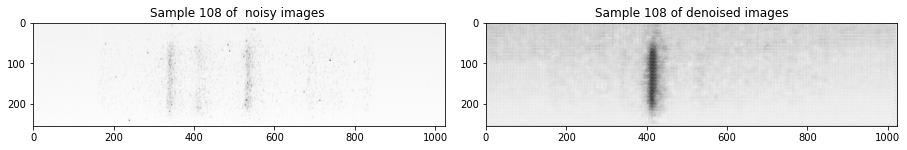

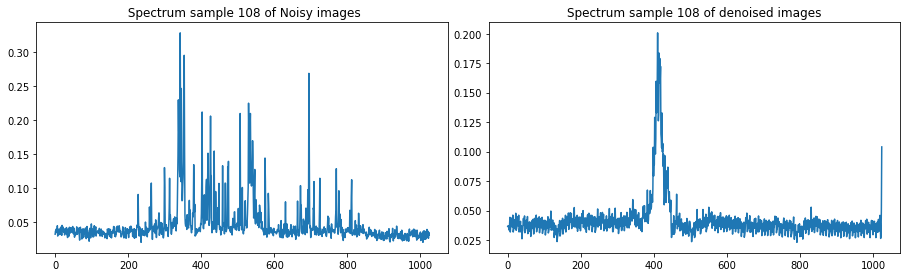

EPOCH 13 / 50
Partial Train loss is 0.0003487865615170449
Partial Train loss is 0.0004192540072835982
Partial Train loss is 0.0003258638025727123
Partial Train loss is 0.00035772836417891085
Partial Train loss is 0.00035756753641180694
Partial Train loss is 0.00032524223206564784
Partial Train loss is 0.000368062115740031
Partial Train loss is 0.0003457395650912076
Partial Train loss is 0.0003348429163452238
Partial Train loss is 0.0003873660753015429
Partial Train loss is 0.0003097273875027895
Partial Train loss is 0.0003012801462318748
Partial Train loss is 0.00036021473351866007
Partial Train loss is 0.0003564774233382195
Partial Train loss is 0.00033225989318452775
Partial Train loss is 0.00029672059463337064
Partial Train loss is 0.0003317341615911573
Partial Train loss is 0.00031185272382572293
Partial Train loss is 0.00031416426645591855
Partial Train loss is 0.0003937316650990397
 
 Global  validation loss for this epoch  is 0.0007637791568413377 

 EPOCH 13/50 	 train loss 0.0

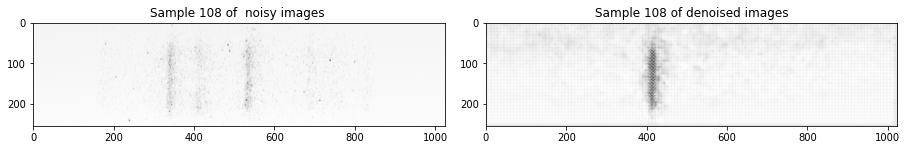

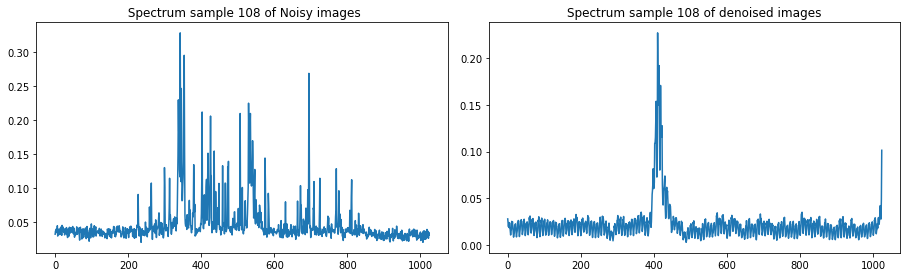

EPOCH 14 / 50
Partial Train loss is 0.00033610884565860033
Partial Train loss is 0.0003989730030298233
Partial Train loss is 0.0003062578907702118
Partial Train loss is 0.00032284174812957644
Partial Train loss is 0.0003364040167070925
Partial Train loss is 0.00030324497492983937
Partial Train loss is 0.00034981188946403563
Partial Train loss is 0.0003178151964675635
Partial Train loss is 0.000312762800604105
Partial Train loss is 0.000371626578271389
Partial Train loss is 0.00029627265757881105
Partial Train loss is 0.00028316458337940276
Partial Train loss is 0.00034096516901627183
Partial Train loss is 0.0003346933808643371
Partial Train loss is 0.0003092549741268158
Partial Train loss is 0.0002800519287120551
Partial Train loss is 0.0003101305046584457
Partial Train loss is 0.00029055922641418874
Partial Train loss is 0.0002944877778645605
Partial Train loss is 0.00036488298792392015
 
 Global  validation loss for this epoch  is 0.00048303641960956156 

 EPOCH 14/50 	 train loss 0.

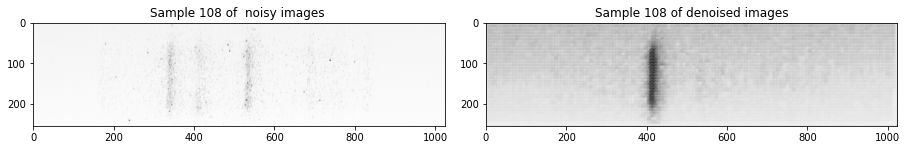

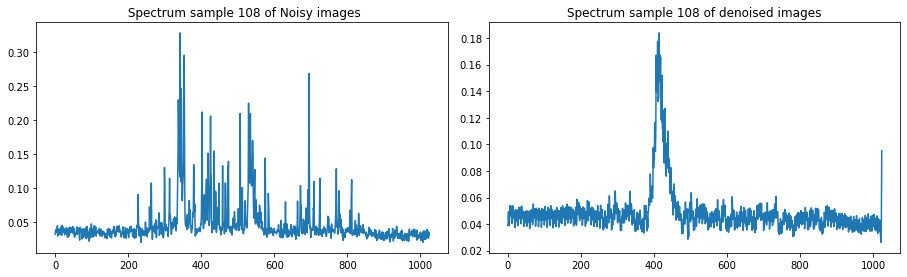

EPOCH 15 / 50
Partial Train loss is 0.0003169172559864819
Partial Train loss is 0.0003719340020325035
Partial Train loss is 0.00029365558293648064
Partial Train loss is 0.00030456852982752025
Partial Train loss is 0.0003217413031961769
Partial Train loss is 0.00028846561326645315
Partial Train loss is 0.00033555913250893354
Partial Train loss is 0.0003023589961230755
Partial Train loss is 0.00029802738572470844
Partial Train loss is 0.00035053654573857784
Partial Train loss is 0.00028124157688580453
Partial Train loss is 0.0002692542038857937
Partial Train loss is 0.00032576321973465383
Partial Train loss is 0.00032104176352731884
Partial Train loss is 0.000298213679343462
Partial Train loss is 0.000268428644631058
Partial Train loss is 0.00029907585121691227
Partial Train loss is 0.0002780610811896622
Partial Train loss is 0.0002840036468114704
Partial Train loss is 0.0003472603566478938
 
 Global  validation loss for this epoch  is 0.00044878601329401135 

 EPOCH 15/50 	 train loss 0

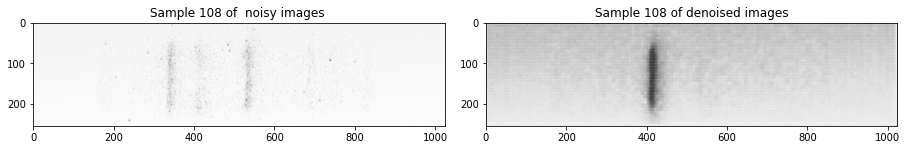

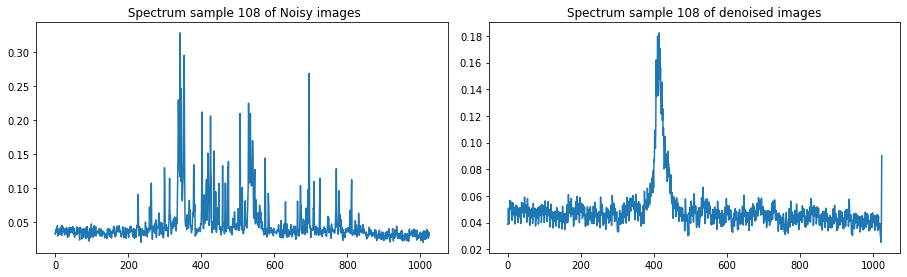

EPOCH 16 / 50
Partial Train loss is 0.0003040777228306979
Partial Train loss is 0.0003575787122827023
Partial Train loss is 0.0002843933762051165
Partial Train loss is 0.0002984966558869928
Partial Train loss is 0.0003108736709691584
Partial Train loss is 0.00028006735374219716
Partial Train loss is 0.0003217992780264467
Partial Train loss is 0.00029451921000145376
Partial Train loss is 0.00028843499603681266
Partial Train loss is 0.00033815979259088635
Partial Train loss is 0.00027486975886859
Partial Train loss is 0.00026054371846839786
Partial Train loss is 0.0003179227642249316
Partial Train loss is 0.00031198421493172646
Partial Train loss is 0.0002875363570638001
Partial Train loss is 0.00026043649995699525
Partial Train loss is 0.0002904655411839485
Partial Train loss is 0.0002706180966924876
Partial Train loss is 0.000274151359917596
Partial Train loss is 0.00033190345857292414
 
 Global  validation loss for this epoch  is 0.0004958077915944159 

 EPOCH 16/50 	 train loss 0.000

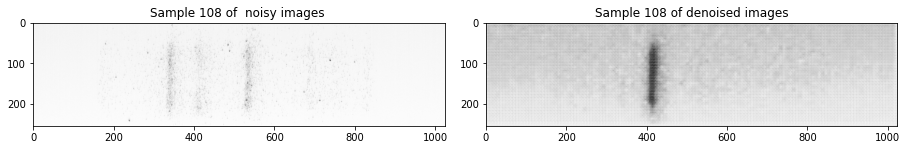

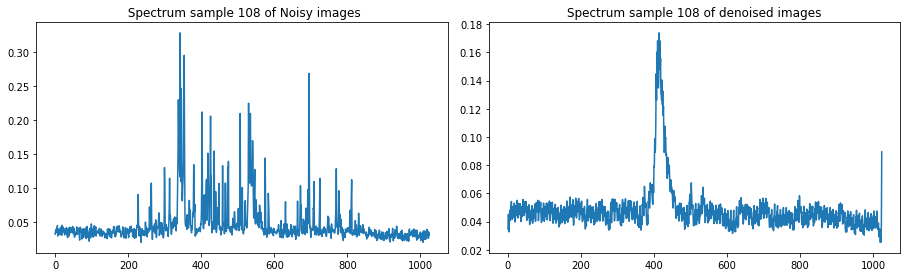

EPOCH 17 / 50
Partial Train loss is 0.0002979601267725229
Partial Train loss is 0.00034605510882101953
Partial Train loss is 0.0002805819094646722
Partial Train loss is 0.0002887844748329371
Partial Train loss is 0.0003023312019649893
Partial Train loss is 0.0002730499836616218
Partial Train loss is 0.00031180292717181146
Partial Train loss is 0.00028641746030189097
Partial Train loss is 0.0002803838870022446
Partial Train loss is 0.00033105164766311646
Partial Train loss is 0.0002686626685317606
Partial Train loss is 0.0002546166651882231
Partial Train loss is 0.00031040405156090856
Partial Train loss is 0.00030465921736322343
Partial Train loss is 0.0002862863475456834
Partial Train loss is 0.00025095403543673456
Partial Train loss is 0.00028783170273527503
Partial Train loss is 0.0002635170239955187
Partial Train loss is 0.00026816228637471795
Partial Train loss is 0.00032780953915789723
 
 Global  validation loss for this epoch  is 0.0003414321690797806 

 EPOCH 17/50 	 train loss 

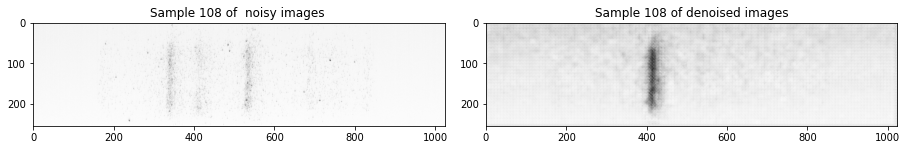

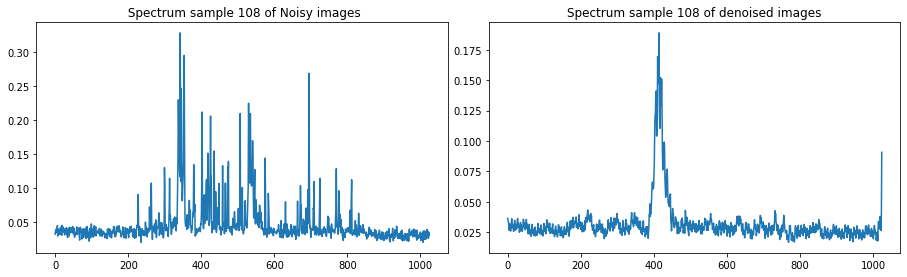

EPOCH 18 / 50
Partial Train loss is 0.00028922452474944293
Partial Train loss is 0.00033990308293141425
Partial Train loss is 0.00027780767413787544
Partial Train loss is 0.0002915854856837541
Partial Train loss is 0.00030136521672829986
Partial Train loss is 0.00027100075385533273
Partial Train loss is 0.0003098307643085718
Partial Train loss is 0.0002878975938074291
Partial Train loss is 0.00027659934130497277
Partial Train loss is 0.00032742484472692013
Partial Train loss is 0.0002594892866909504
Partial Train loss is 0.00024998863227665424
Partial Train loss is 0.00029997603269293904
Partial Train loss is 0.0003019064315594733
Partial Train loss is 0.0002818852080963552
Partial Train loss is 0.00024799664970487356
Partial Train loss is 0.000283230358036235
Partial Train loss is 0.00025858209119178355
Partial Train loss is 0.000263008289039135
Partial Train loss is 0.0003212692972738296
 
 Global  validation loss for this epoch  is 0.0003190489951521158 

 EPOCH 18/50 	 train loss 0

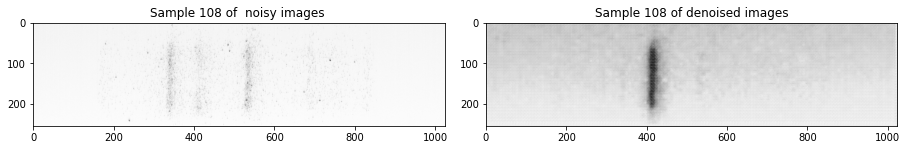

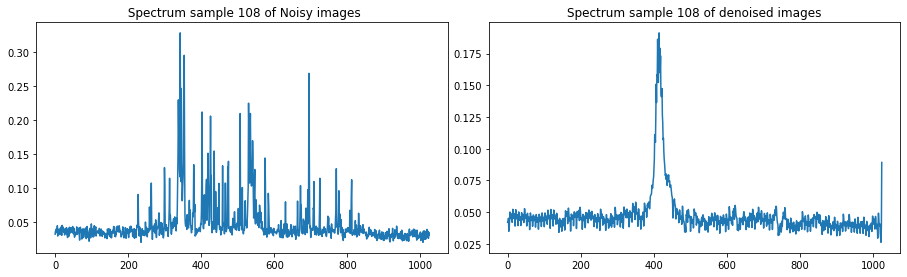

EPOCH 19 / 50
Partial Train loss is 0.0002857681247405708
Partial Train loss is 0.00033669223194010556
Partial Train loss is 0.0002724966616369784
Partial Train loss is 0.0002953485818579793
Partial Train loss is 0.0002990787324961275
Partial Train loss is 0.0002650856040418148
Partial Train loss is 0.00030516358674503863
Partial Train loss is 0.0002838745422195643
Partial Train loss is 0.00027315912302583456
Partial Train loss is 0.0003222222439944744
Partial Train loss is 0.0002571392396930605
Partial Train loss is 0.0002490766055416316
Partial Train loss is 0.00029569637263193727
Partial Train loss is 0.00029572565108537674
Partial Train loss is 0.0002738658513408154
Partial Train loss is 0.0002445520949549973
Partial Train loss is 0.00027672163560055196
Partial Train loss is 0.0002554439124651253
Partial Train loss is 0.00025811721570789814
Partial Train loss is 0.0003152926219627261
 
 Global  validation loss for this epoch  is 0.0004582771798595786 

 EPOCH 19/50 	 train loss 0.0

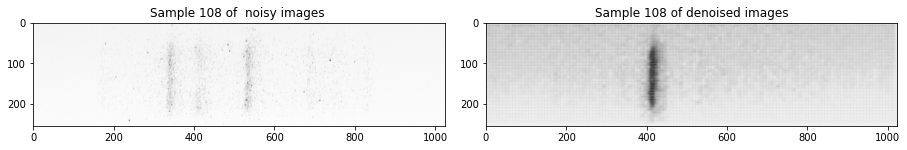

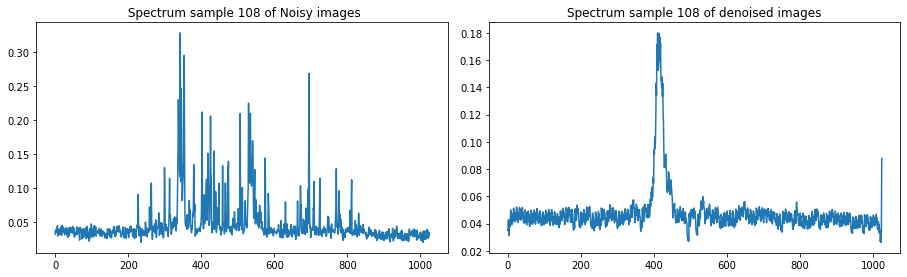

EPOCH 20 / 50
Partial Train loss is 0.00028302520513534546
Partial Train loss is 0.0003309117164462805
Partial Train loss is 0.00026861063088290393
Partial Train loss is 0.00027652463177219033
Partial Train loss is 0.00028640442178584635
Partial Train loss is 0.0002603500324767083
Partial Train loss is 0.0002995999820996076
Partial Train loss is 0.0002723301586229354
Partial Train loss is 0.00026863746461458504
Partial Train loss is 0.00031963377841748297
Partial Train loss is 0.0002562345762271434
Partial Train loss is 0.0002457227965351194
Partial Train loss is 0.0002947718312498182
Partial Train loss is 0.00029124479624442756
Partial Train loss is 0.00027346922433935106
Partial Train loss is 0.00024353717162739486
Partial Train loss is 0.00027570099337026477
Partial Train loss is 0.000254718994256109
Partial Train loss is 0.0002560829743742943
Partial Train loss is 0.00031217417563311756
 
 Global  validation loss for this epoch  is 0.0003155282174702734 

 EPOCH 20/50 	 train loss 

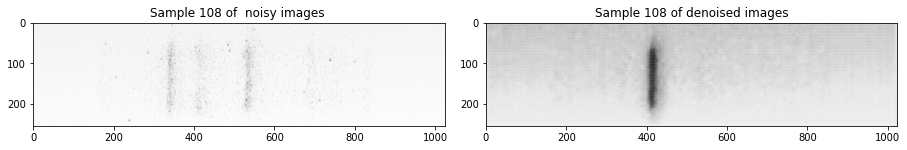

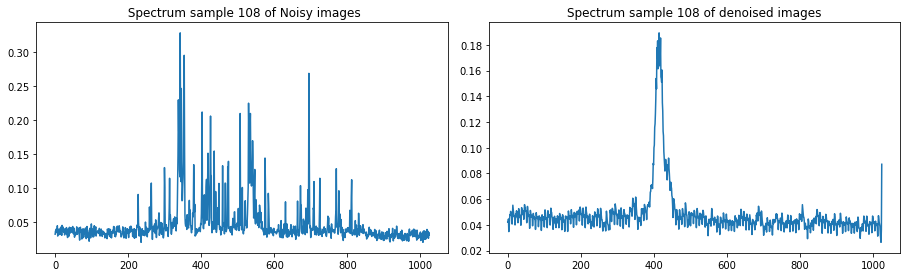

EPOCH 21 / 50
Partial Train loss is 0.00027946956106461585
Partial Train loss is 0.00032779021421447396
Partial Train loss is 0.0002652253897394985
Partial Train loss is 0.00027959648286923766
Partial Train loss is 0.00028477085288614035
Partial Train loss is 0.00025848569930531085
Partial Train loss is 0.0002959448902402073
Partial Train loss is 0.0002690059773158282
Partial Train loss is 0.0002652399707585573
Partial Train loss is 0.0003152471035718918
Partial Train loss is 0.00025194886256940663
Partial Train loss is 0.0002425399434287101
Partial Train loss is 0.0002869355957955122
Partial Train loss is 0.00028899978497065604
Partial Train loss is 0.00026436522603034973
Partial Train loss is 0.00024097626737784594
Partial Train loss is 0.00026738550513982773
Partial Train loss is 0.00025186294806189835
Partial Train loss is 0.00025104658561758697
Partial Train loss is 0.0003089749370701611
 
 Global  validation loss for this epoch  is 0.0003767359012272209 

 EPOCH 21/50 	 train los

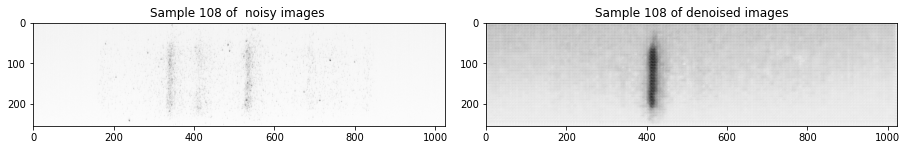

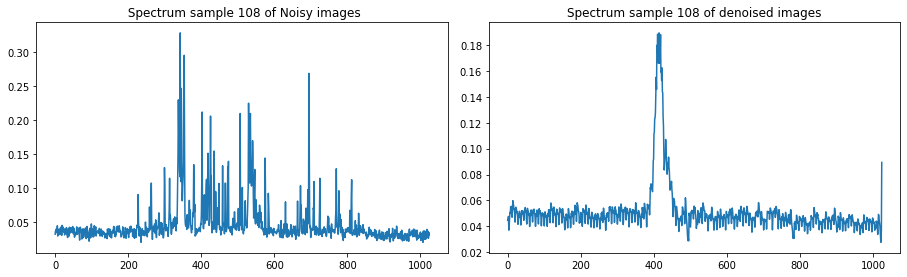

EPOCH 22 / 50
Partial Train loss is 0.0002796218905132264
Partial Train loss is 0.00032236656988970935
Partial Train loss is 0.0002629017399158329
Partial Train loss is 0.00026959762908518314
Partial Train loss is 0.00028129093698225915
Partial Train loss is 0.00025300326524302363
Partial Train loss is 0.0002935690281447023
Partial Train loss is 0.00026914957561530173
Partial Train loss is 0.00026202015578746796
Partial Train loss is 0.00031618899083696306
Partial Train loss is 0.0002553143713157624
Partial Train loss is 0.00024118581495713443
Partial Train loss is 0.00029084013658575714
Partial Train loss is 0.00028916847077198327
Partial Train loss is 0.0002646458160597831
Partial Train loss is 0.00023933504417072982
Partial Train loss is 0.00026690028607845306
Partial Train loss is 0.0002493937499821186
Partial Train loss is 0.00024873457732610404
Partial Train loss is 0.00030604141647927463
 
 Global  validation loss for this epoch  is 0.00046751380432397127 

 EPOCH 22/50 	 train 

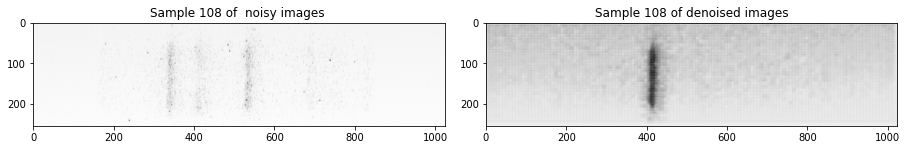

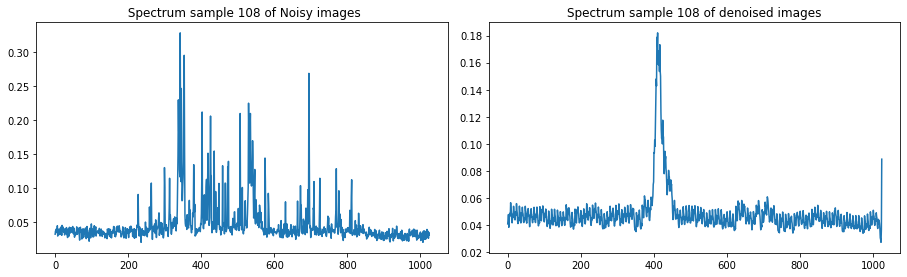

EPOCH 23 / 50
Partial Train loss is 0.00027904941816814244
Partial Train loss is 0.0003208103298675269
Partial Train loss is 0.00025742099387571216
Partial Train loss is 0.00026911351596936584
Partial Train loss is 0.0002778373600449413
Partial Train loss is 0.0002518874825909734
Partial Train loss is 0.0002883777196984738
Partial Train loss is 0.0002657943987287581
Partial Train loss is 0.00026109805912710726
Partial Train loss is 0.00031988898990675807
Partial Train loss is 0.00024908073828555644
Partial Train loss is 0.00023897139180917293
Partial Train loss is 0.00028770099743269384
Partial Train loss is 0.00028858345467597246
Partial Train loss is 0.0002629724331200123
Partial Train loss is 0.00023662169405724853
Partial Train loss is 0.00026510003954172134
Partial Train loss is 0.0002460915711708367
Partial Train loss is 0.000245947070652619
Partial Train loss is 0.00030379797681234777
 
 Global  validation loss for this epoch  is 0.00048543416778557 

 EPOCH 23/50 	 train loss 0

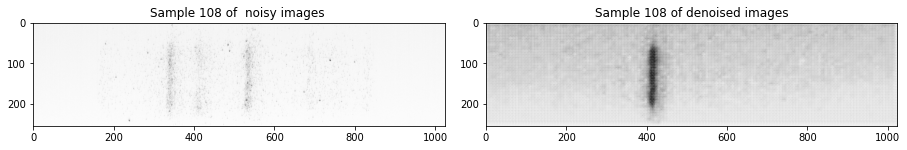

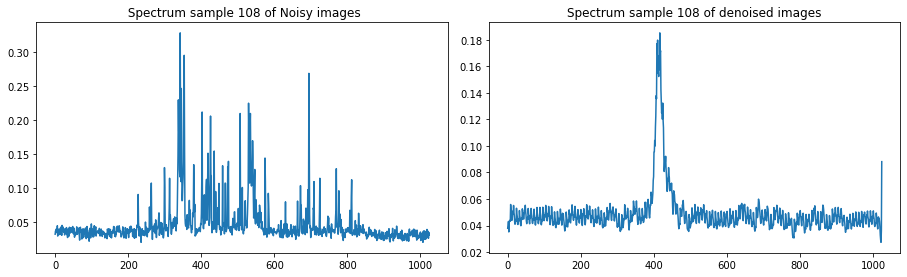

EPOCH 24 / 50
Partial Train loss is 0.00027635242440737784
Partial Train loss is 0.00031882632174529135
Partial Train loss is 0.0002603841421660036
Partial Train loss is 0.00027332259924151003
Partial Train loss is 0.0002773691958282143
Partial Train loss is 0.0002526611788198352
Partial Train loss is 0.0002880032698158175
Partial Train loss is 0.00026598043041303754
Partial Train loss is 0.00026040032389573753
Partial Train loss is 0.0003181076608598232
Partial Train loss is 0.00024692146689631045
Partial Train loss is 0.00023823171795811504
Partial Train loss is 0.0002840974775608629
Partial Train loss is 0.00028873240808025
Partial Train loss is 0.0002580296713858843
Partial Train loss is 0.00023970431357156485
Partial Train loss is 0.00026064785197377205
Partial Train loss is 0.00024497738922946155
Partial Train loss is 0.00024425957235507667
Partial Train loss is 0.00030028197215870023
 
 Global  validation loss for this epoch  is 0.00024047378974501044 

 EPOCH 24/50 	 train loss

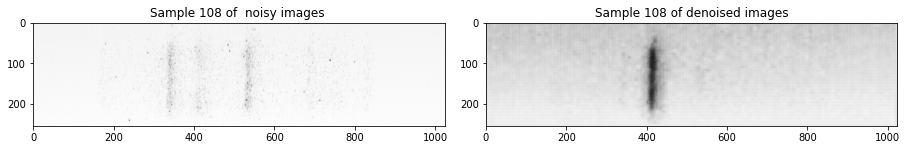

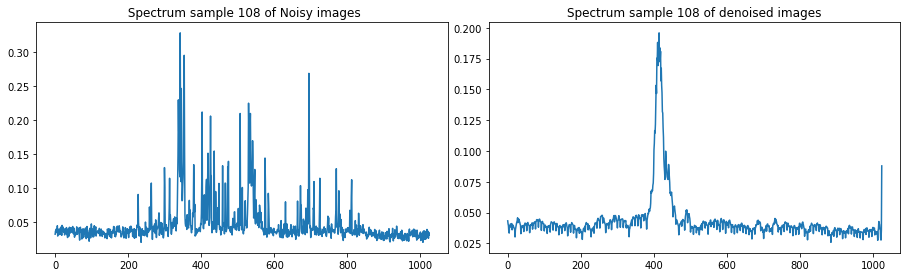

EPOCH 25 / 50
Partial Train loss is 0.00027332748868502676
Partial Train loss is 0.00031679062522016466
Partial Train loss is 0.00025830816593952477
Partial Train loss is 0.00027098404825665057
Partial Train loss is 0.00027716028853319585
Partial Train loss is 0.0002517012180760503
Partial Train loss is 0.0002875671489164233
Partial Train loss is 0.0002663135528564453
Partial Train loss is 0.00025904475478455424
Partial Train loss is 0.00031383015448227525
Partial Train loss is 0.0002496789675205946
Partial Train loss is 0.00023692923423368484
Partial Train loss is 0.0002826174895744771
Partial Train loss is 0.0002866742725018412
Partial Train loss is 0.00026025777333416045
Partial Train loss is 0.0002351933653699234
Partial Train loss is 0.00026820856146514416
Partial Train loss is 0.0002447726728860289
Partial Train loss is 0.00024305905390065163
Partial Train loss is 0.0003040422743652016
 
 Global  validation loss for this epoch  is 0.0006272334139794111 

 EPOCH 25/50 	 train loss

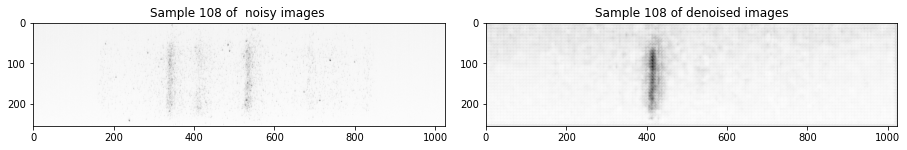

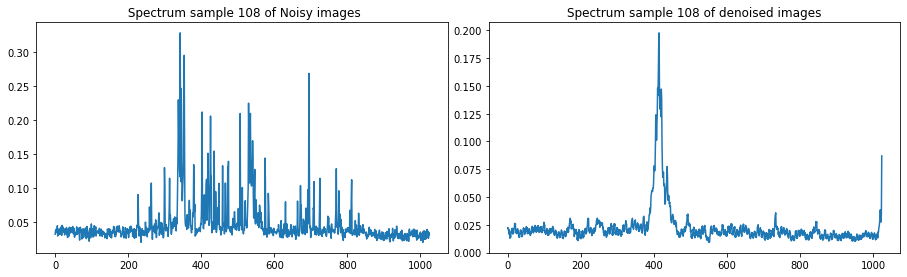

EPOCH 26 / 50
Partial Train loss is 0.0002736003079917282
Partial Train loss is 0.0003159689949825406
Partial Train loss is 0.0002616459096316248
Partial Train loss is 0.00027405950822867453
Partial Train loss is 0.0002777096815407276
Partial Train loss is 0.0002524397859815508
Partial Train loss is 0.0002846272836904973
Partial Train loss is 0.00027013247017748654
Partial Train loss is 0.0002599009021651
Partial Train loss is 0.0003215459582861513
Partial Train loss is 0.0002455501235090196
Partial Train loss is 0.00023651556693948805
Partial Train loss is 0.0002789950813166797
Partial Train loss is 0.0002824495895765722
Partial Train loss is 0.00025410583475604653
Partial Train loss is 0.00023381000210065395
Partial Train loss is 0.0002588251663837582
Partial Train loss is 0.00024244886299129575
Partial Train loss is 0.0002414078189758584
Partial Train loss is 0.00030166428769007325
 
 Global  validation loss for this epoch  is 0.0003939397574868053 

 EPOCH 26/50 	 train loss 0.000 

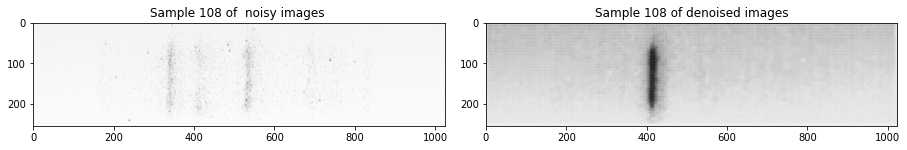

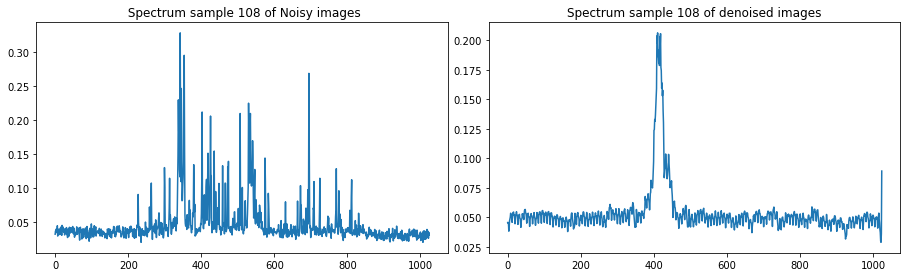

EPOCH 27 / 50
Partial Train loss is 0.0002901475818362087
Partial Train loss is 0.0003194655291736126
Partial Train loss is 0.00024849301553331316
Partial Train loss is 0.00024820369435474277
Partial Train loss is 0.0002689009706955403
Partial Train loss is 0.00024099017900880426
Partial Train loss is 0.00028756711981259286
Partial Train loss is 0.0002545999886933714
Partial Train loss is 0.0002542681759223342
Partial Train loss is 0.00030867470195516944
Partial Train loss is 0.00024632588610984385
Partial Train loss is 0.00023572822101414204
Partial Train loss is 0.0002846061543095857
Partial Train loss is 0.0002799637441057712
Partial Train loss is 0.0002672786940820515
Partial Train loss is 0.00023320525360759348
Partial Train loss is 0.00027894144295714796
Partial Train loss is 0.0002451975306030363
Partial Train loss is 0.00024427869357168674
Partial Train loss is 0.00029766224906779826
 
 Global  validation loss for this epoch  is 0.0005844253464601934 

 EPOCH 27/50 	 train loss

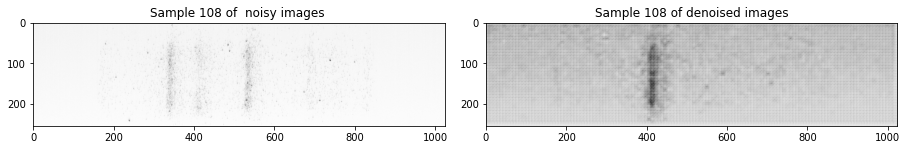

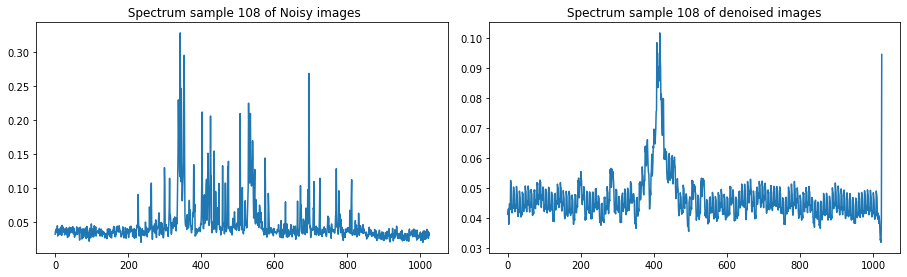

EPOCH 28 / 50
Partial Train loss is 0.00027477051480673254
Partial Train loss is 0.0003144828078802675
Partial Train loss is 0.0002524831797927618
Partial Train loss is 0.00027140480233356357
Partial Train loss is 0.0002756425819825381
Partial Train loss is 0.0002502555144019425
Partial Train loss is 0.0002814259787555784
Partial Train loss is 0.00026233762037009
Partial Train loss is 0.00025650355382822454
Partial Train loss is 0.0003132671117782593
Partial Train loss is 0.00024268669949378818
Partial Train loss is 0.00023475375201087445
Partial Train loss is 0.00027611307450570166
Partial Train loss is 0.00028101756470277905
Partial Train loss is 0.0002568643249105662
Partial Train loss is 0.0002309068077011034
Partial Train loss is 0.00025935808662325144
Partial Train loss is 0.00024305131228175014
Partial Train loss is 0.0002394164475845173
Partial Train loss is 0.0002972214133478701
 
 Global  validation loss for this epoch  is 0.0006058604922145605 

 EPOCH 28/50 	 train loss 0.0

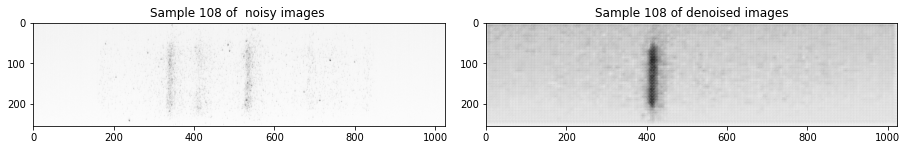

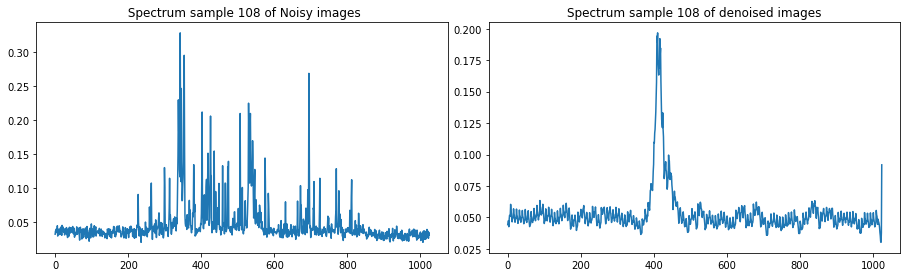

EPOCH 29 / 50
Partial Train loss is 0.0002738492621574551
Partial Train loss is 0.0003132029087282717
Partial Train loss is 0.0002531166828703135
Partial Train loss is 0.0002634554693941027
Partial Train loss is 0.0002721085329540074
Partial Train loss is 0.0002482003183104098
Partial Train loss is 0.00028541238862089813
Partial Train loss is 0.0002570711076259613
Partial Train loss is 0.00025604720576666296
Partial Train loss is 0.00030655969749204814
Partial Train loss is 0.0002596637059468776
Partial Train loss is 0.00023873169266153127
Partial Train loss is 0.00028836954152211547
Partial Train loss is 0.0002896435034926981
Partial Train loss is 0.0002596437989268452
Partial Train loss is 0.00023493636399507523
Partial Train loss is 0.0002586205955594778
Partial Train loss is 0.00024532046518288553
Partial Train loss is 0.00024178021703846753
Partial Train loss is 0.0002988996566273272
 
 Global  validation loss for this epoch  is 0.0006493202527053654 

 EPOCH 29/50 	 train loss 0.

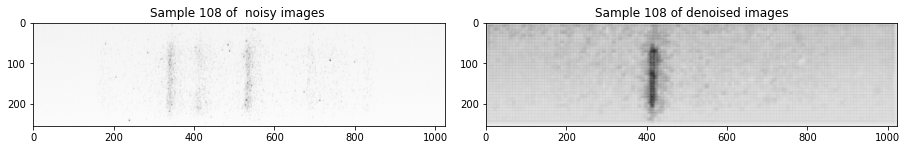

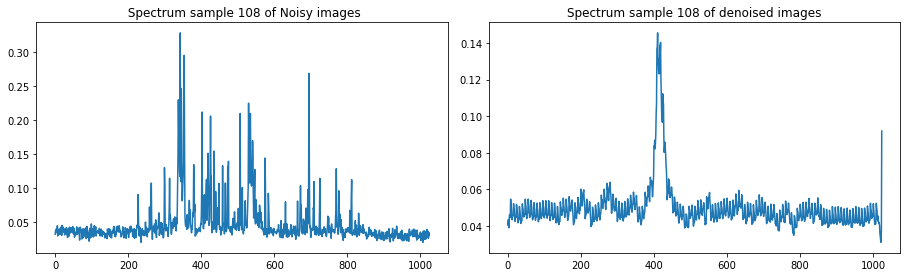

EPOCH 30 / 50
Partial Train loss is 0.00027181729092262685
Partial Train loss is 0.0003128916723653674
Partial Train loss is 0.0002632570394780487
Partial Train loss is 0.00025838433066383004
Partial Train loss is 0.0002739810443017632
Partial Train loss is 0.0002421926474198699
Partial Train loss is 0.00028431019745767117
Partial Train loss is 0.00025870100944302976
Partial Train loss is 0.00025555025786161423
Partial Train loss is 0.00030996990972198546
Partial Train loss is 0.00023902420070953667
Partial Train loss is 0.0002333765587536618
Partial Train loss is 0.00027245120145380497
Partial Train loss is 0.00027730068541131914
Partial Train loss is 0.0002586593327578157
Partial Train loss is 0.00023007919662632048
Partial Train loss is 0.00025604176335036755
Partial Train loss is 0.00023846780823078007
Partial Train loss is 0.0002376650954829529
Partial Train loss is 0.000299775943858549
 
 Global  validation loss for this epoch  is 0.0003996700106654316 

 EPOCH 30/50 	 train loss

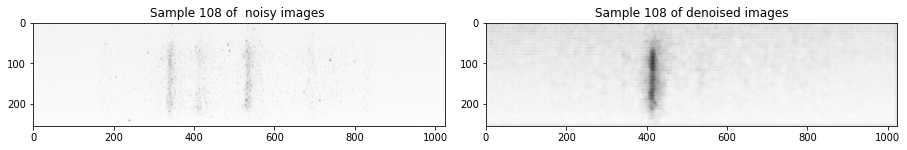

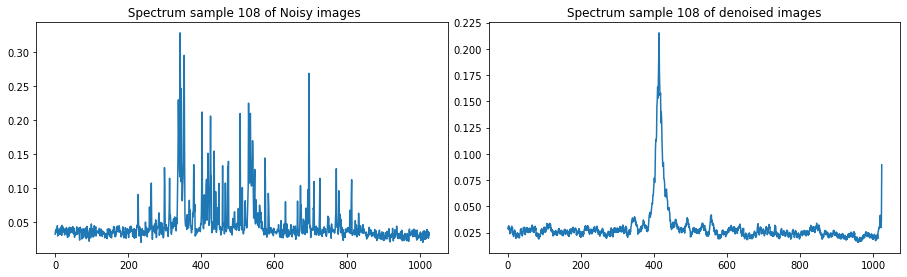

EPOCH 31 / 50
Partial Train loss is 0.00026766012888401747
Partial Train loss is 0.0003128697571810335
Partial Train loss is 0.0002621574967633933
Partial Train loss is 0.0002745223173405975
Partial Train loss is 0.0002780915820039809
Partial Train loss is 0.0002479680406395346
Partial Train loss is 0.00028378848219290376
Partial Train loss is 0.000271026132395491
Partial Train loss is 0.0002610454976093024
Partial Train loss is 0.0003246951964683831
Partial Train loss is 0.00024293805472552776
Partial Train loss is 0.0002342394582228735
Partial Train loss is 0.0002747380349319428
Partial Train loss is 0.00027801768737845123
Partial Train loss is 0.0002497050154488534
Partial Train loss is 0.00023200587020255625
Partial Train loss is 0.00025216309586539865
Partial Train loss is 0.00023829936981201172
Partial Train loss is 0.00023660257284063846
Partial Train loss is 0.00030252450960688293
 
 Global  validation loss for this epoch  is 0.0005899471580050886 

 EPOCH 31/50 	 train loss 0.

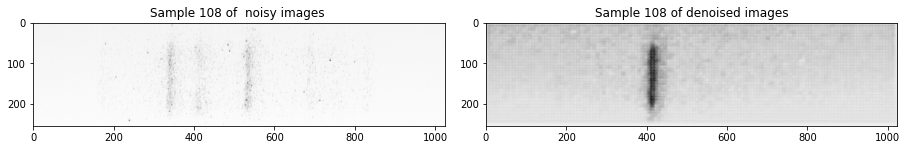

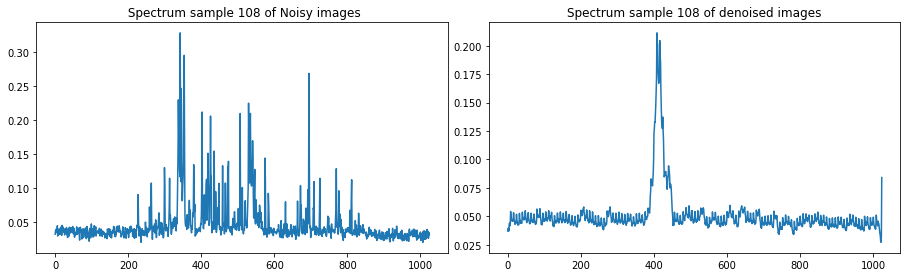

EPOCH 32 / 50
Partial Train loss is 0.00027061838773079216
Partial Train loss is 0.0003105861251242459
Partial Train loss is 0.00025623603141866624
Partial Train loss is 0.00026684184558689594
Partial Train loss is 0.0002711012784857303
Partial Train loss is 0.00024235155433416367
Partial Train loss is 0.0002829348377417773
Partial Train loss is 0.00025648903101682663
Partial Train loss is 0.00025345126050524414
Partial Train loss is 0.0003114856081083417
Partial Train loss is 0.00023824091476853937
Partial Train loss is 0.00023151391360443085
Partial Train loss is 0.0002718195610214025
Partial Train loss is 0.00027726247208192945
Partial Train loss is 0.00024841970298439264
Partial Train loss is 0.00023255780979525298
Partial Train loss is 0.0002522005815990269
Partial Train loss is 0.00023801138740964234
Partial Train loss is 0.00023624235473107547
Partial Train loss is 0.0003000824945047498
 
 Global  validation loss for this epoch  is 0.0005839202785864472 

 EPOCH 32/50 	 train lo

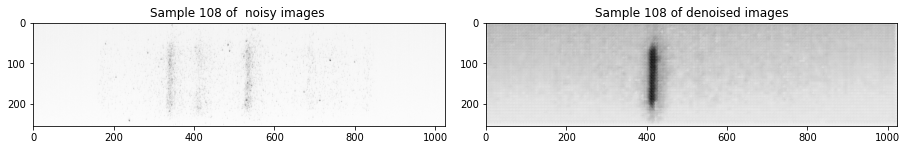

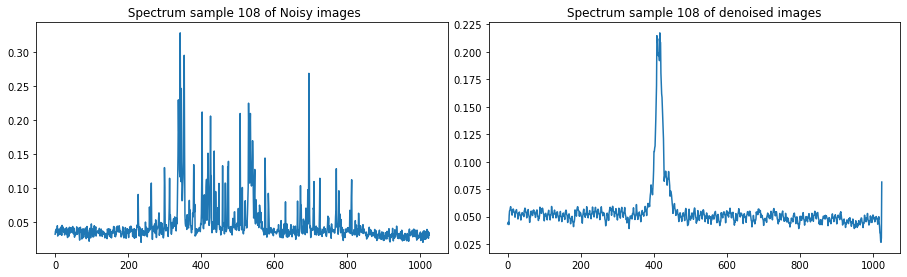

EPOCH 33 / 50
Partial Train loss is 0.0002672902774065733
Partial Train loss is 0.0003095176361966878
Partial Train loss is 0.00025853156694211066
Partial Train loss is 0.00026894346228800714
Partial Train loss is 0.0002727204991970211
Partial Train loss is 0.00024368392769247293
Partial Train loss is 0.0002810165751725435
Partial Train loss is 0.00025924816145561635
Partial Train loss is 0.00025563346571289003
Partial Train loss is 0.0003084388154093176
Partial Train loss is 0.00024470032076351345
Partial Train loss is 0.00023048161529004574
Partial Train loss is 0.0002727090031839907
Partial Train loss is 0.00027546394267119467
Partial Train loss is 0.00024922454031184316
Partial Train loss is 0.00023057493672240525
Partial Train loss is 0.0002527903707232326
Partial Train loss is 0.00023822039656806737
Partial Train loss is 0.00023570714984089136
Partial Train loss is 0.0002969198685605079
 
 Global  validation loss for this epoch  is 0.0002864076814148575 

 EPOCH 33/50 	 train los

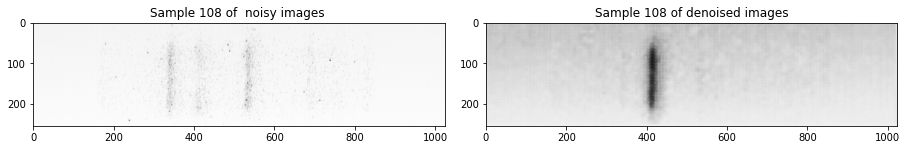

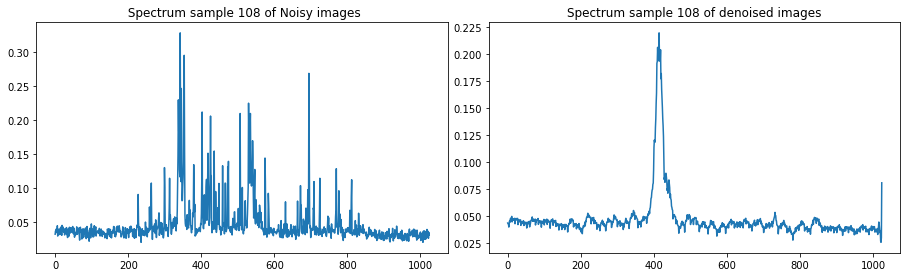

EPOCH 34 / 50
Partial Train loss is 0.0002681333280634135
Partial Train loss is 0.00031229123123921454
Partial Train loss is 0.0002550773206166923
Partial Train loss is 0.0002639363519847393
Partial Train loss is 0.0002707212697714567
Partial Train loss is 0.00024285927065648139
Partial Train loss is 0.00028364386525936425
Partial Train loss is 0.00025551478029228747
Partial Train loss is 0.0002552721998654306
Partial Train loss is 0.0003112532140221447
Partial Train loss is 0.00023751045227982104
Partial Train loss is 0.0002313619916094467
Partial Train loss is 0.00026942064869217575
Partial Train loss is 0.0002746100362855941
Partial Train loss is 0.00025350780924782157
Partial Train loss is 0.00022944888041820377
Partial Train loss is 0.0002547646581660956
Partial Train loss is 0.00023724390484858304
Partial Train loss is 0.0002363285020692274
Partial Train loss is 0.00029580076807178557
 
 Global  validation loss for this epoch  is 0.0002659132005646825 

 EPOCH 34/50 	 train loss 

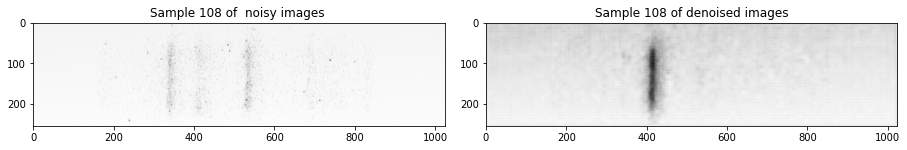

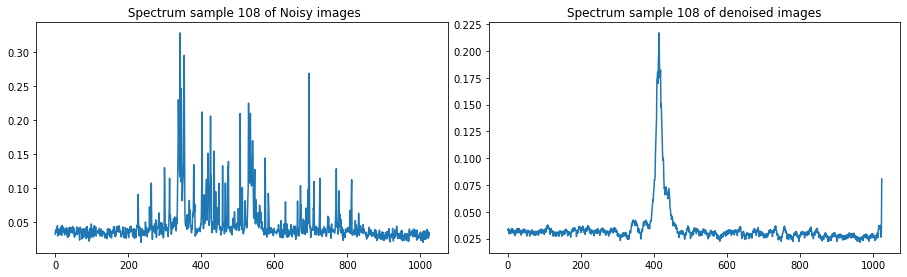

EPOCH 35 / 50
Partial Train loss is 0.0002661488833837211
Partial Train loss is 0.00030899918056093156
Partial Train loss is 0.00025789704523049295
Partial Train loss is 0.00026928054285235703
Partial Train loss is 0.0002751201973296702
Partial Train loss is 0.0002427008730592206
Partial Train loss is 0.00028109116829000413
Partial Train loss is 0.0002609446819406003
Partial Train loss is 0.00025363292661495507
Partial Train loss is 0.00031304461299441755
Partial Train loss is 0.00023891763703431934
Partial Train loss is 0.00023197669361252338
Partial Train loss is 0.0002719719777815044
Partial Train loss is 0.0002779158821795136
Partial Train loss is 0.0002503094729036093
Partial Train loss is 0.00022833533876109868
Partial Train loss is 0.00025323775480501354
Partial Train loss is 0.0002363853418501094
Partial Train loss is 0.00023394897289108485
Partial Train loss is 0.0002923355787061155
 
 Global  validation loss for this epoch  is 0.00023404155217576772 

 EPOCH 35/50 	 train los

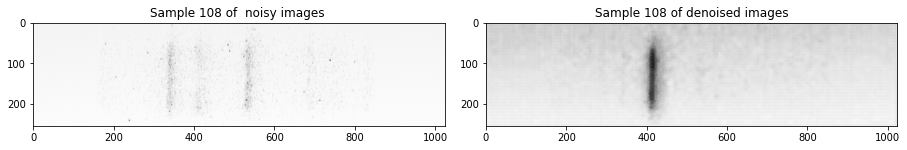

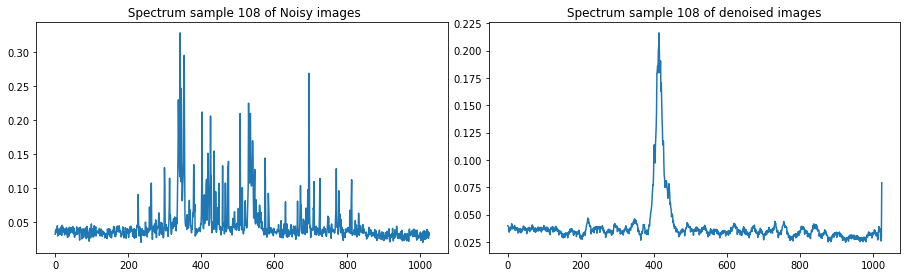

EPOCH 36 / 50
Partial Train loss is 0.00026716277352534235
Partial Train loss is 0.00031209332519210875
Partial Train loss is 0.0002462402917444706
Partial Train loss is 0.0002612961980048567
Partial Train loss is 0.0002692688431125134
Partial Train loss is 0.0002409354638075456
Partial Train loss is 0.00028443511109799147
Partial Train loss is 0.0002482995332684368
Partial Train loss is 0.00025069352705031633
Partial Train loss is 0.0003006680926773697
Partial Train loss is 0.00024684573872946203
Partial Train loss is 0.00022914240253157914
Partial Train loss is 0.0002746325917541981
Partial Train loss is 0.00027555093402042985
Partial Train loss is 0.00025933730648830533
Partial Train loss is 0.00022657529916614294
Partial Train loss is 0.00026003914535976946
Partial Train loss is 0.000237560598179698
Partial Train loss is 0.0002359359059482813
Partial Train loss is 0.0002896992664318532
 
 Global  validation loss for this epoch  is 0.0006166621460579336 

 EPOCH 36/50 	 train loss 0

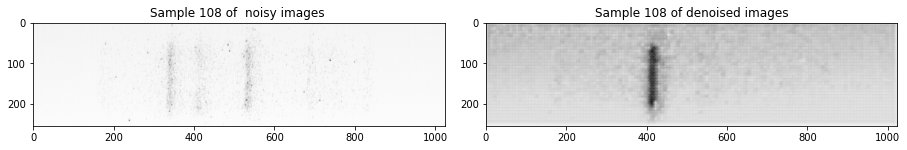

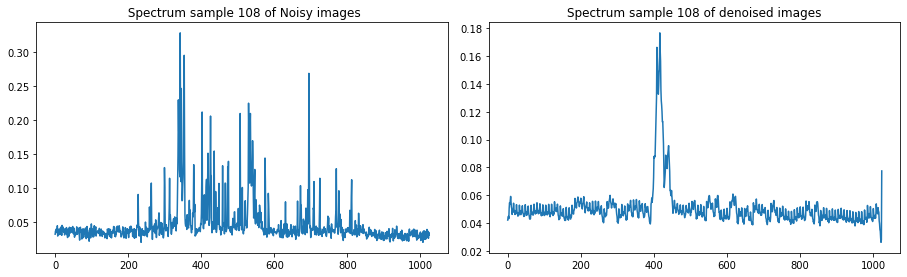

EPOCH 37 / 50
Partial Train loss is 0.0002663772611413151
Partial Train loss is 0.00030512548983097076
Partial Train loss is 0.0002629083173815161
Partial Train loss is 0.00027103690081276
Partial Train loss is 0.0002738573239184916
Partial Train loss is 0.00024286894768010825
Partial Train loss is 0.0002813654427882284
Partial Train loss is 0.000264633446931839
Partial Train loss is 0.00025533675216138363
Partial Train loss is 0.000315709097776562
Partial Train loss is 0.00023776140005793422
Partial Train loss is 0.00023226183839142323
Partial Train loss is 0.00026822087238542736
Partial Train loss is 0.00027403919375501573
Partial Train loss is 0.00024962963652797043
Partial Train loss is 0.00022859766613692045
Partial Train loss is 0.0002516050008125603
Partial Train loss is 0.00023586656607221812
Partial Train loss is 0.0002337153273401782
Partial Train loss is 0.00029645193717442453
 
 Global  validation loss for this epoch  is 0.00025344366440549493 

 EPOCH 37/50 	 train loss 0.

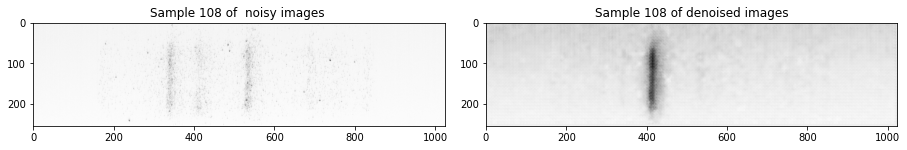

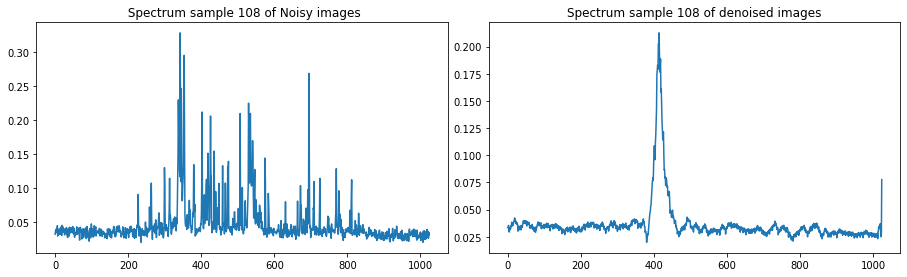

EPOCH 38 / 50
Partial Train loss is 0.00026813914882950485
Partial Train loss is 0.00030808811425231397
Partial Train loss is 0.00025422568432986736
Partial Train loss is 0.00026105536380782723
Partial Train loss is 0.00026938720839098096
Partial Train loss is 0.00024143831979017705
Partial Train loss is 0.0002833859180100262
Partial Train loss is 0.00024972789105959237
Partial Train loss is 0.00025161061785183847
Partial Train loss is 0.00030410653562285006
Partial Train loss is 0.00024397434026468545
Partial Train loss is 0.00022973259910941124
Partial Train loss is 0.0002717708412092179
Partial Train loss is 0.00027560791932046413
Partial Train loss is 0.00029090564930811524
Partial Train loss is 0.00023094043717719615
Partial Train loss is 0.00027290196157991886
Partial Train loss is 0.0002482965064700693
Partial Train loss is 0.0002431021857773885
Partial Train loss is 0.00031341580324806273
 
 Global  validation loss for this epoch  is 0.0005025899154134095 

 EPOCH 38/50 	 train

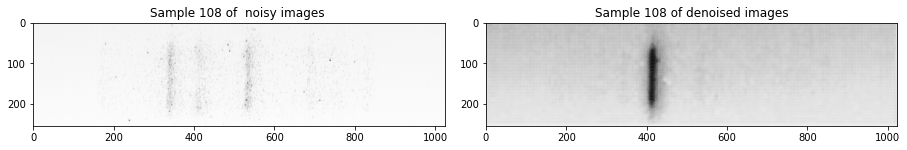

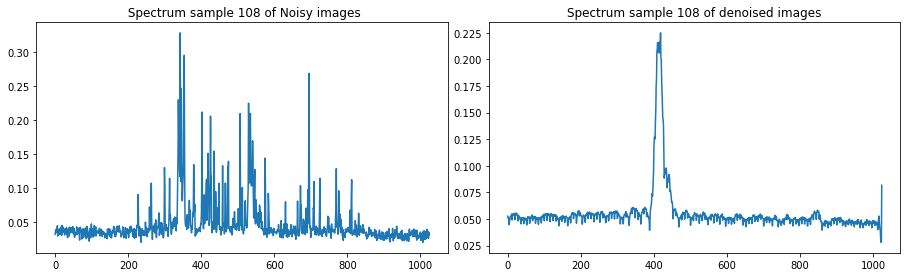

EPOCH 39 / 50
Partial Train loss is 0.00027257739566266537
Partial Train loss is 0.00031353600206784904
Partial Train loss is 0.0002651939576026052
Partial Train loss is 0.00027623758069239557
Partial Train loss is 0.0002756153407972306
Partial Train loss is 0.00025075770099647343
Partial Train loss is 0.0002836902276612818
Partial Train loss is 0.0002632034011185169
Partial Train loss is 0.000255676539381966
Partial Train loss is 0.0003102084738202393
Partial Train loss is 0.0002467774029355496
Partial Train loss is 0.00023186612816061825
Partial Train loss is 0.00028595395269803703
Partial Train loss is 0.00028224647394381464
Partial Train loss is 0.00026022069505415857
Partial Train loss is 0.00022819424339104444
Partial Train loss is 0.00026084078126586974
Partial Train loss is 0.0002390055888099596
Partial Train loss is 0.00023553520441055298
Partial Train loss is 0.00029223941965028644
 
 Global  validation loss for this epoch  is 0.0006111689144745469 

 EPOCH 39/50 	 train loss

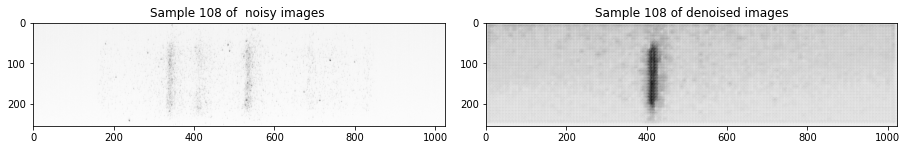

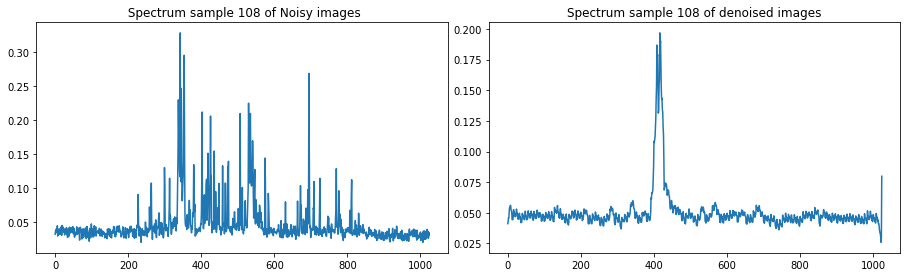

EPOCH 40 / 50
Partial Train loss is 0.00027126757777296007
Partial Train loss is 0.0003132599813397974
Partial Train loss is 0.00024987378856167197
Partial Train loss is 0.00026288931258022785
Partial Train loss is 0.00027405773289501667
Partial Train loss is 0.0002407922875136137
Partial Train loss is 0.00028339511482045054
Partial Train loss is 0.0002552758378442377
Partial Train loss is 0.0002524258161429316
Partial Train loss is 0.0003025509067811072
Partial Train loss is 0.0002404910046607256
Partial Train loss is 0.00022985658142715693
Partial Train loss is 0.00026968991733156145
Partial Train loss is 0.0002704589569475502
Partial Train loss is 0.00025237450608983636
Partial Train loss is 0.00022669523605145514
Partial Train loss is 0.0002541558933444321
Partial Train loss is 0.00023662825697101653
Partial Train loss is 0.0002378144854446873
Partial Train loss is 0.00029700633604079485
 
 Global  validation loss for this epoch  is 0.00041528925066813827 

 EPOCH 40/50 	 train los

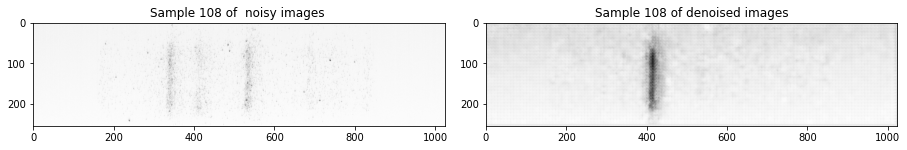

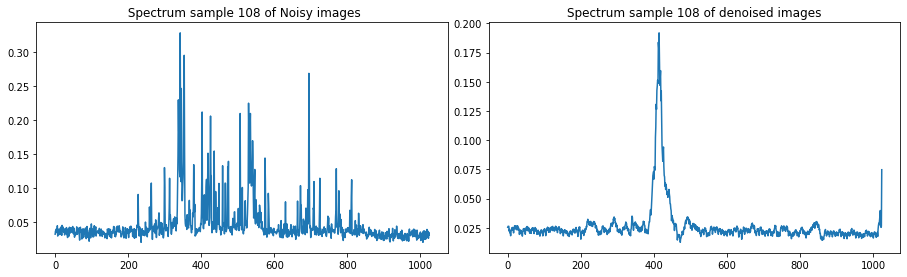

EPOCH 41 / 50
Partial Train loss is 0.0002649043162818998
Partial Train loss is 0.00031450457754544914
Partial Train loss is 0.0002465637226123363
Partial Train loss is 0.00026209207135252655
Partial Train loss is 0.00027047909679822624
Partial Train loss is 0.00024050050706136972
Partial Train loss is 0.00028243029373697937
Partial Train loss is 0.00025725836167111993
Partial Train loss is 0.00025404381449334323
Partial Train loss is 0.00031129957642406225
Partial Train loss is 0.0002335838507860899
Partial Train loss is 0.00023201496514957398
Partial Train loss is 0.0002681721525732428
Partial Train loss is 0.0002749647246673703
Partial Train loss is 0.0002476136723998934
Partial Train loss is 0.00022888071544002742
Partial Train loss is 0.0002506139862816781
Partial Train loss is 0.0002373142633587122
Partial Train loss is 0.00023356452584266663
Partial Train loss is 0.0003002881130669266
 
 Global  validation loss for this epoch  is 0.0006415240350179374 

 EPOCH 41/50 	 train loss

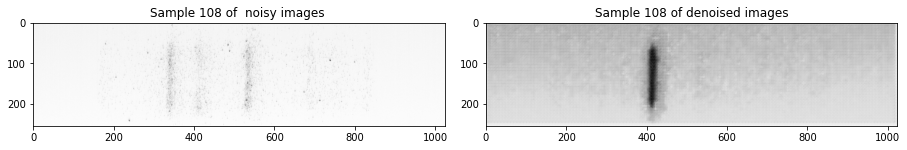

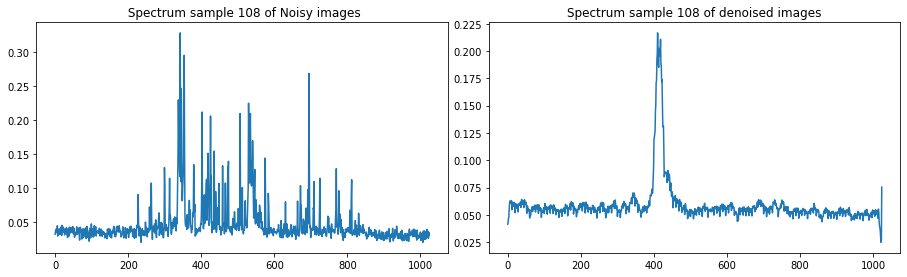

EPOCH 42 / 50
Partial Train loss is 0.0002664156199898571
Partial Train loss is 0.0003083918709307909
Partial Train loss is 0.00025517784524708986
Partial Train loss is 0.0002600942680146545
Partial Train loss is 0.0002688297245185822
Partial Train loss is 0.00024140979803632945
Partial Train loss is 0.00028151142760179937
Partial Train loss is 0.00024996374850161374
Partial Train loss is 0.0002506463788449764
Partial Train loss is 0.00030549903749488294
Partial Train loss is 0.0002531963982619345
Partial Train loss is 0.00023354508448392153
Partial Train loss is 0.0002821249363478273
Partial Train loss is 0.000279107567621395
Partial Train loss is 0.00025063843349926174
Partial Train loss is 0.0002342597144888714
Partial Train loss is 0.0002536637184675783
Partial Train loss is 0.00023984249855857342
Partial Train loss is 0.00023382389917969704
Partial Train loss is 0.0002903002896346152
 
 Global  validation loss for this epoch  is 0.00023868207063060254 

 EPOCH 42/50 	 train loss 0

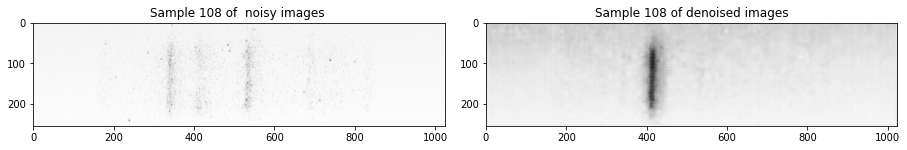

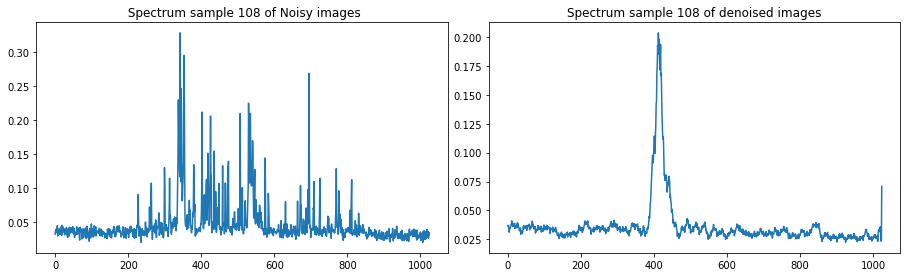

EPOCH 43 / 50
Partial Train loss is 0.0002675878640729934
Partial Train loss is 0.0003065479686483741
Partial Train loss is 0.000256746425293386
Partial Train loss is 0.00025584452669136226
Partial Train loss is 0.0002699264441616833
Partial Train loss is 0.00023673326359130442
Partial Train loss is 0.00028021761681884527
Partial Train loss is 0.0002542334550525993
Partial Train loss is 0.00024860381381586194
Partial Train loss is 0.00030749390134587884
Partial Train loss is 0.0002301841595908627
Partial Train loss is 0.00023107505694497377
Partial Train loss is 0.00026776897720992565
Partial Train loss is 0.0002686438092496246
Partial Train loss is 0.000250674580456689
Partial Train loss is 0.0002266298542963341
Partial Train loss is 0.00025005967472679913
Partial Train loss is 0.00023525206779595464
Partial Train loss is 0.0002334638120373711
Partial Train loss is 0.0003013546229340136
 
 Global  validation loss for this epoch  is 0.0005345009849406779 

 EPOCH 43/50 	 train loss 0.0

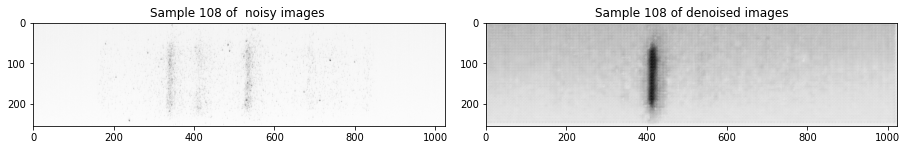

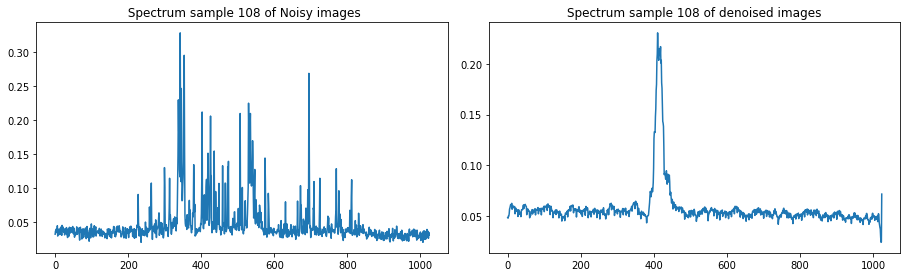

EPOCH 44 / 50
Partial Train loss is 0.00026827011606656015
Partial Train loss is 0.0003091405378654599
Partial Train loss is 0.00025133517920039594
Partial Train loss is 0.00025300317793153226
Partial Train loss is 0.0002698300813790411
Partial Train loss is 0.0002401068777544424
Partial Train loss is 0.00028329278575256467
Partial Train loss is 0.000252097932389006
Partial Train loss is 0.00024898885749280453
Partial Train loss is 0.00030224505462683737
Partial Train loss is 0.00024135671264957637
Partial Train loss is 0.00023048305592965335
Partial Train loss is 0.000271563942078501
Partial Train loss is 0.000271192955551669
Partial Train loss is 0.00025024174829013646
Partial Train loss is 0.0002281468186993152
Partial Train loss is 0.00025325591559521854
Partial Train loss is 0.0002375409530941397
Partial Train loss is 0.00023455677728634328
Partial Train loss is 0.00029246072517707944
 
 Global  validation loss for this epoch  is 0.0006584785296581686 

 EPOCH 44/50 	 train loss 0

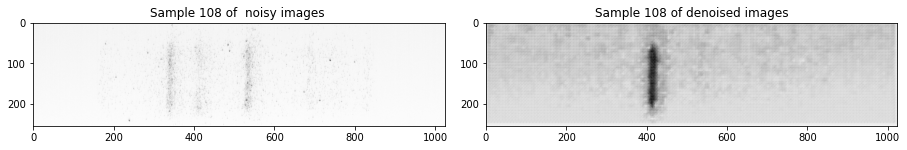

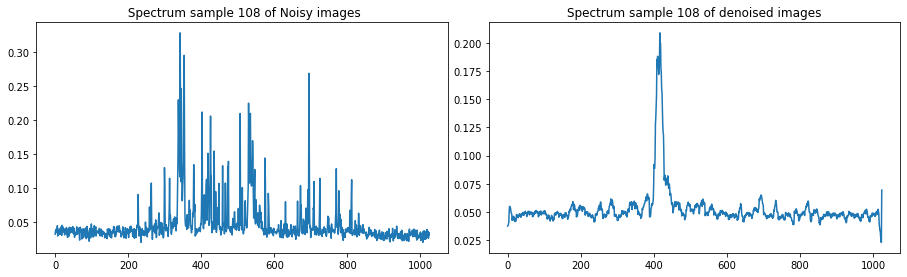

EPOCH 45 / 50
Partial Train loss is 0.0002665311039891094
Partial Train loss is 0.0003071074897889048
Partial Train loss is 0.00025009334785863757
Partial Train loss is 0.00025330865173600614
Partial Train loss is 0.0002663448394741863
Partial Train loss is 0.0002359873178647831
Partial Train loss is 0.0002802467788569629
Partial Train loss is 0.00024933498934842646
Partial Train loss is 0.0002484491269569844
Partial Train loss is 0.0003037713177036494
Partial Train loss is 0.0002361627557547763
Partial Train loss is 0.00022923779033590108
Partial Train loss is 0.0002667166409082711
Partial Train loss is 0.0002724061196204275
Partial Train loss is 0.00024980909074656665
Partial Train loss is 0.00022697052918374538
Partial Train loss is 0.0002504019357729703
Partial Train loss is 0.00023548414174001664
Partial Train loss is 0.000233647515415214
Partial Train loss is 0.0002926501620095223
 
 Global  validation loss for this epoch  is 0.0002350740833207965 

 EPOCH 45/50 	 train loss 0.00

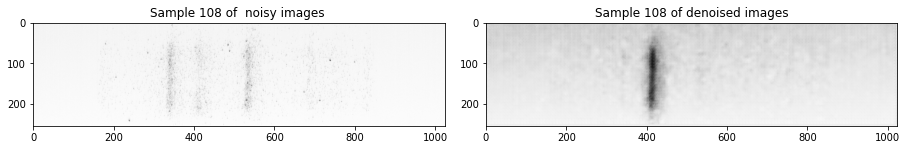

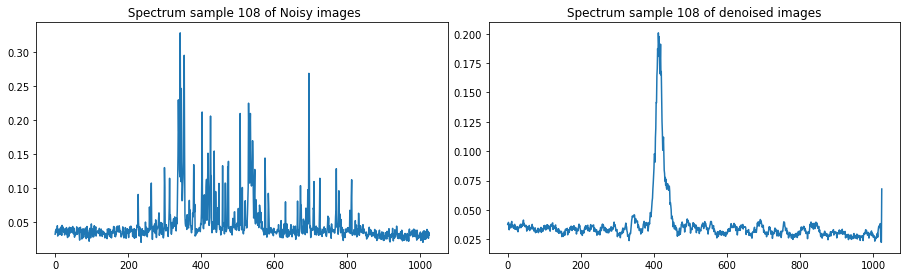

EPOCH 46 / 50
Partial Train loss is 0.0002650295209605247
Partial Train loss is 0.00030604423955082893
Partial Train loss is 0.00025074390578083694
Partial Train loss is 0.0002590667281765491
Partial Train loss is 0.00026964026619680226
Partial Train loss is 0.0002394613402429968
Partial Train loss is 0.0002804198011290282
Partial Train loss is 0.0002527920878492296
Partial Train loss is 0.00024897517869248986
Partial Train loss is 0.0002990974171552807
Partial Train loss is 0.0002451496256981045
Partial Train loss is 0.00022881818586029112
Partial Train loss is 0.0002694420691113919
Partial Train loss is 0.0002741307544056326
Partial Train loss is 0.0002511278144083917
Partial Train loss is 0.00022768127382732928
Partial Train loss is 0.0002518048568163067
Partial Train loss is 0.00023686132044531405
Partial Train loss is 0.00023356378369498998
Partial Train loss is 0.0002922183775808662
 
 Global  validation loss for this epoch  is 0.0004743972094729543 

 EPOCH 46/50 	 train loss 0.

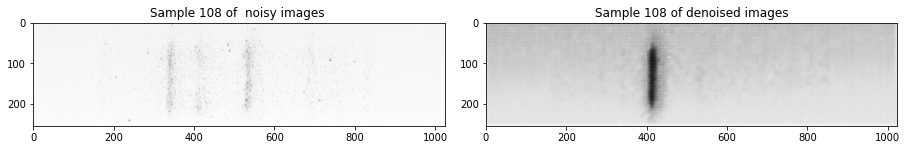

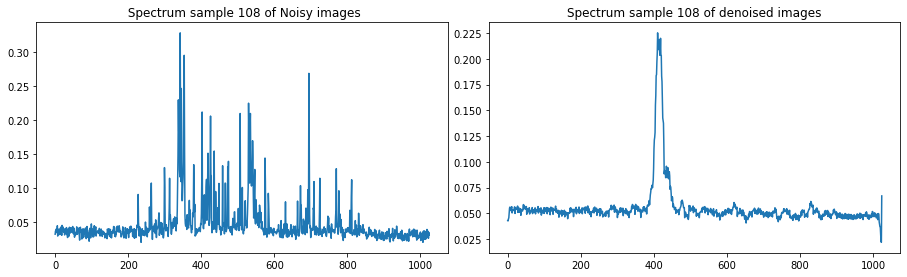

EPOCH 47 / 50
Partial Train loss is 0.000265130860498175
Partial Train loss is 0.00030950206564739347
Partial Train loss is 0.0002519371919333935
Partial Train loss is 0.000253669306403026
Partial Train loss is 0.0002676730218809098
Partial Train loss is 0.00023869951837696135
Partial Train loss is 0.00028126692632213235
Partial Train loss is 0.0002531656646169722
Partial Train loss is 0.0002507655299268663
Partial Train loss is 0.0003044339537154883
Partial Train loss is 0.00024808882153593004
Partial Train loss is 0.00022961902141105384
Partial Train loss is 0.00027196999872103333
Partial Train loss is 0.0002732782159000635
Partial Train loss is 0.000251307210419327
Partial Train loss is 0.00023025371774565428
Partial Train loss is 0.00025285608717240393
Partial Train loss is 0.00023852124286349863
Partial Train loss is 0.00023555615916848183
Partial Train loss is 0.0002934402727987617
 
 Global  validation loss for this epoch  is 0.000283922505332157 

 EPOCH 47/50 	 train loss 0.00

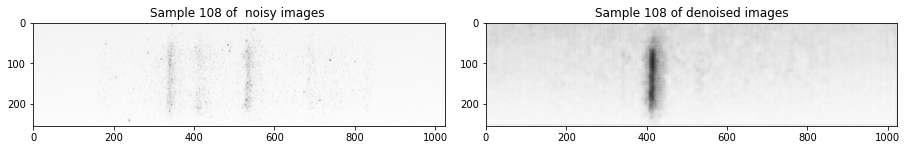

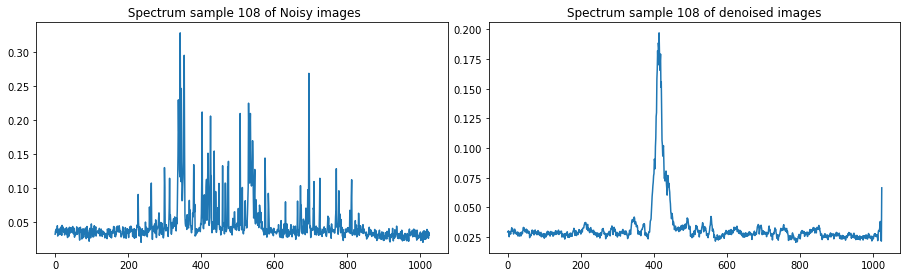

EPOCH 48 / 50
Partial Train loss is 0.00026514483033679426
Partial Train loss is 0.0003048870130442083
Partial Train loss is 0.00025785903562791646
Partial Train loss is 0.00025455158902332187
Partial Train loss is 0.0002678613818716258
Partial Train loss is 0.00023606186732649803
Partial Train loss is 0.00027864176081493497
Partial Train loss is 0.0002537107502575964
Partial Train loss is 0.00025173259200528264
Partial Train loss is 0.0003071341780014336
Partial Train loss is 0.00025013359845615923
Partial Train loss is 0.0002294330479344353
Partial Train loss is 0.00027310807490721345
Partial Train loss is 0.00027330900775268674
Partial Train loss is 0.0002478739188518375
Partial Train loss is 0.0002323992521269247
Partial Train loss is 0.0002507032477296889
Partial Train loss is 0.0002390029840171337
Partial Train loss is 0.00023403884551953524
Partial Train loss is 0.00029408736736513674
 
 Global  validation loss for this epoch  is 0.0003804557491093874 

 EPOCH 48/50 	 train loss

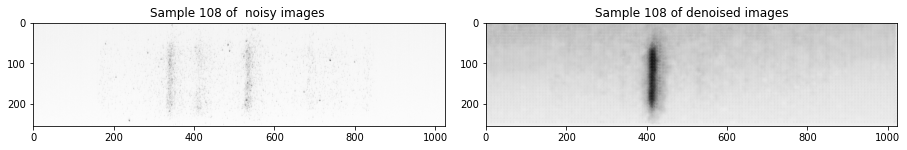

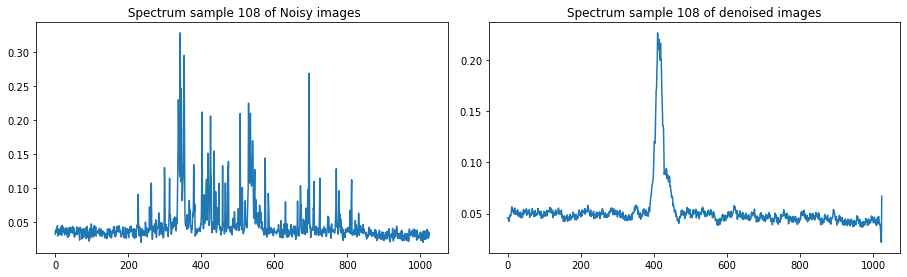

EPOCH 49 / 50
Partial Train loss is 0.00026669257204048336
Partial Train loss is 0.0003025406913366169
Partial Train loss is 0.00025659907259978354
Partial Train loss is 0.0002508018515072763
Partial Train loss is 0.00026671841624192894
Partial Train loss is 0.00023436224728357047
Partial Train loss is 0.00027878969558514655
Partial Train loss is 0.0002523279981687665
Partial Train loss is 0.00024969197693280876
Partial Train loss is 0.00030510654323734343
Partial Train loss is 0.0002448735467623919
Partial Train loss is 0.0002302127395523712
Partial Train loss is 0.0002699598262552172
Partial Train loss is 0.0002691397094167769
Partial Train loss is 0.00024943301104940474
Partial Train loss is 0.0002280464832438156
Partial Train loss is 0.00024927264894358814
Partial Train loss is 0.00023655142285861075
Partial Train loss is 0.0002329099952476099
Partial Train loss is 0.00029057590290904045
 
 Global  validation loss for this epoch  is 0.0005530826165340841 

 EPOCH 49/50 	 train loss

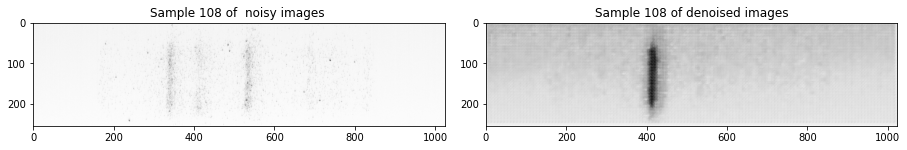

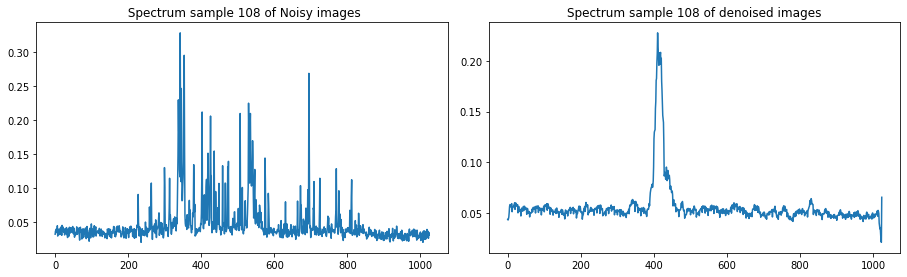

EPOCH 50 / 50
Partial Train loss is 0.00026775692822411656
Partial Train loss is 0.00030449157929979265
Partial Train loss is 0.00025333897792734206
Partial Train loss is 0.0002537470718380064
Partial Train loss is 0.0002685090876184404
Partial Train loss is 0.00023587048053741455
Partial Train loss is 0.0002794658939819783
Partial Train loss is 0.00025222485419362783
Partial Train loss is 0.00024979154113680124
Partial Train loss is 0.0003033338871318847
Partial Train loss is 0.00024345191195607185
Partial Train loss is 0.0002290557895321399
Partial Train loss is 0.0002682354534044862
Partial Train loss is 0.0002693649148568511
Partial Train loss is 0.00025197950890287757
Partial Train loss is 0.00022630004968959838
Partial Train loss is 0.0002508672478143126
Partial Train loss is 0.0002358109486522153
Partial Train loss is 0.00023412086011376232
Partial Train loss is 0.0002911970077548176
 
 Global  validation loss for this epoch  is 0.00029028201242908835 

 EPOCH 50/50 	 train loss

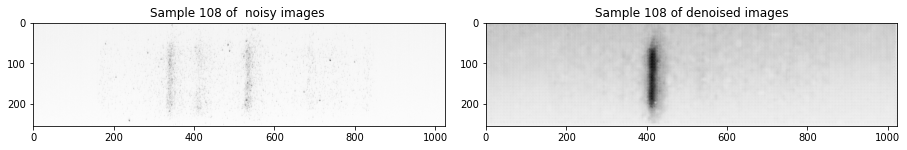

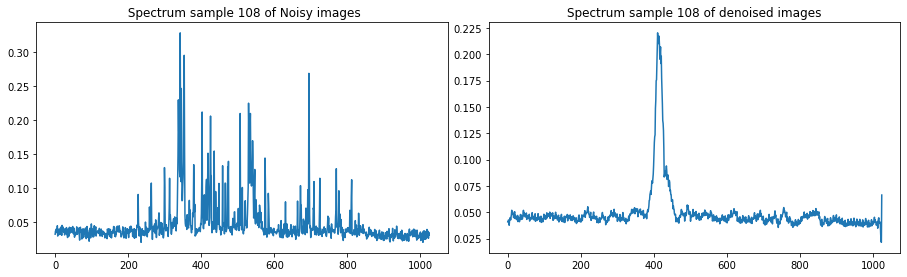

In [17]:
### Training cycle
## For each epoch, we call the training function and validation function and at the end we apply the DAE on our noisy images and show the results
num_epochs = 50
history_da={'train_loss':[],'val_loss':[]}
train_losss,vali_losses=[],[]
for epoch in range(num_epochs):
    print('EPOCH {} / {}'.format(epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,
        noise_fac=noise_factor)
    ### Validation  (use the validation function)
    val_loss = vali_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,
        noise_fac=noise_factor)
    # Print Validation loss
    #history_da['train_loss'].append(train_loss)
    #history_da['val_loss'].append(val_loss)
    train_losss.append(train_loss)
    vali_losses.append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    denoised=plotting(test_dataset,encoder,decoder,rand) # appling the DAE on our noisy images
    
    
    
    

# Final Analysis


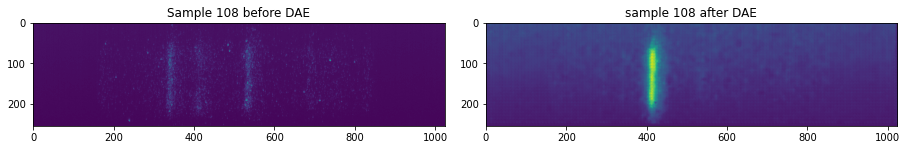

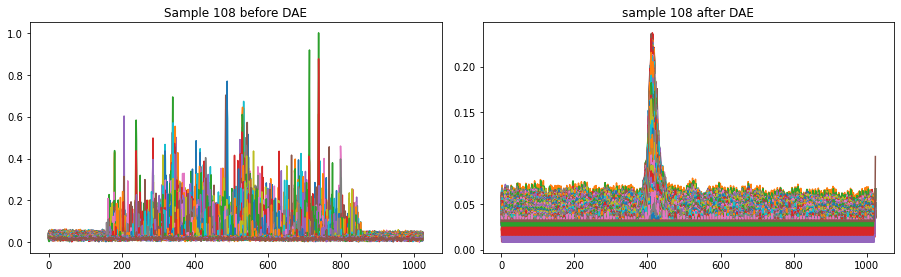

In [31]:
# showing the final results after the last epoch but this time images are in original colormap ( previous one were binary) 
final=denoised#.cpu().permute(0,2,3,1).squeeze().numpy()
for i in range(1):
    plt.subplot(1,2,2)
    plt.imshow(final[rand+i])
    plt.title('sample {} after DAE'.format(rand+i))
    plt.subplot(1,2,1)
    plt.imshow(noise[rand+i])
    plt.title('Sample {} before DAE'.format(rand+i))
    plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
    plt.show()
    
    
    
x=np.linspace(0,1024,1024)
for i in range(1):
    for j in range(256):
        
        plt.subplot(1,2,2)
        plt.plot(x,denoised[rand+i][j])
        plt.title('sample {} after DAE'.format(rand+i))
        plt.subplot(1,2,1)
        plt.plot(x,noise[rand+i][j])
        plt.title('Sample {} before DAE'.format(rand+i))
        plt.subplots_adjust(left=1,
                    bottom=0.1, 
                    right=3, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2) 
    plt.show()

(0.0, 0.01)

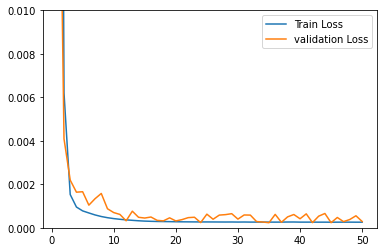

In [29]:
plt.plot(np.linspace(1,epoch+1,epoch+1),train_losss,label='Train Loss')
plt.plot(np.linspace(1,epoch+1,epoch+1),vali_losses,label='validation Loss')
plt.legend()
plt.ylim(0,10**(-2))

/tmp/ipykernel_293/935150500.py:88: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Mnd1= np.asarray(Mnd)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/

Relative error at center of capillary: 0.010088218254405229


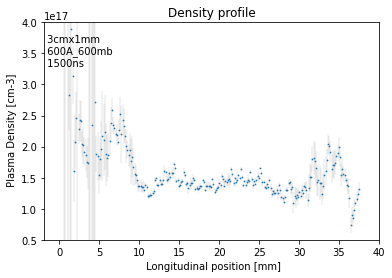

In [32]:
# and here, by fitting , we measure the density and plot the density profile
post_anal, dc, tk= main(denoised)
beaut(post_anal, dc, tk)